# Project 4: Football matches as mobility networks
During a football match, players move on the field to attack and defend. This generates a series of movements that can be analyzed to understand the players behavior.<br><br>
The student should use the `Wyscout open dataset`, describing the “events” in all matches of seven competitions (e.g., passes, shots, tackles etc.), to analyze pass chains and the mobility of football players. A player’s movement is defined by consecutive events made by that player in the match.<br><br>
- <b>Investigate the distances traveled by players during their matches and their distributions. Discuss about the similarity of these distributions with those about mobility trajectories seen during the course.</b><br><br>
- Relate the pass chains made by teams with the probability of making a shot, a goal, and to win a match. Are long chains more likely to lead to a shot/goal? Are short pass chains more successful?<br><br>
- Quantify the predictability of pass chains based on some division of the football field (tessellation). To what extent can we predict the next tile (field zone) where the ball will be? Use a next-location predictor to quantify the accuracy to predict the next zone the ball will be.

The dataset can be download here: https://figshare.com/collections/Soccer_match_event_dataset/4415000/2.

`utils.py` is a file where there are some methods used in this and the other notebooks generated for the project.

In [ ]:
import json
import pandas as pd
from utils import *

import warnings
warnings.filterwarnings('ignore')

### Data load

In [2]:
# loading the events data
events={}
nations = ['Italy','England','Germany','France','Spain','European_Championship','World_Cup']
for nation in nations:
    with open('./data/events/events_%s.json' %nation) as json_data:
        events[nation] = json.load(json_data)

# loading the players data
players={}
with open('./data/players.json') as json_data:
    players = json.load(json_data)

# loading the match data
matches={}
for nation in nations:
    with open('./data/matches/matches_%s.json' %nation) as json_data:
        matches[nation] = json.load(json_data)

### JSON to DataFrame

In [3]:
players_df = pd.DataFrame(players)

events_df = {
    'Italy': pd.DataFrame(events['Italy']),
    'England': pd.DataFrame(events['England']),
    'Germany': pd.DataFrame(events['Germany']),
    'France': pd.DataFrame(events['France']),
    'Spain': pd.DataFrame(events['Spain']),
    'European_Championship': pd.DataFrame(events['European_Championship']),
    'World_Cup': pd.DataFrame(events['World_Cup'])
}

matches_df = {
    'Italy': pd.DataFrame(matches['Italy']),
    'England': pd.DataFrame(matches['England']),
    'Germany': pd.DataFrame(matches['Germany']),
    'France': pd.DataFrame(matches['France']),
    'Spain': pd.DataFrame(matches['Spain']),
    'European_Championship': pd.DataFrame(matches['European_Championship']),
    'World_Cup': pd.DataFrame(matches['World_Cup'])
}

### Some data preparation

With the function `prepare_players`, only the columns `playerId` and `role` of the `players_df` DataFrame are kept, in order to use this information to make further analysis, based on the role of each player. Look at the `utils.py` file for further information.

In [4]:
players_df.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


In [5]:
players_df = prepare_players(players_df)

In [6]:
players_df.head()

,role,playerId
0,GK,32777
1,DF,393228
2,GK,393230
3,MD,32793
4,DF,393247


In this way, we will merge the 'role' information with the events generated by each player and we can evaluate their traveled distances.

Before starting the analysis, there is also a kind of **trajectory filtering** to do. In fact, all the events with _Goal Kick_ and _Save attempt_ are removed from all the DataFrames, since they all have a dummy value as a starting position, which can be either {'y': 0, 'x': 0} or {'y': 100, 'x': 100} and they would influence and modify the real distance traveled by goalkeepers. (Reference: https://dataglossary.wyscout.com/goal_kick/).

In [7]:
events_to_check = pd.DataFrame()
for nation in events_df:
    goal_kick_events = events_df[nation][(events_df[nation]['subEventName'] == 'Goal kick')]
    save_attempt_events = events_df[nation][(events_df[nation]['eventName'] == 'Save attempt')]
    events_to_check = pd.concat([events_to_check, goal_kick_events, save_attempt_events])
    print(nation, len(goal_kick_events), len(save_attempt_events))

Italy 6518 3561
England 6061 3349
Germany 4847 2811
France 6254 3436
Spain 6045 3410
European_Championship 963 492
World_Cup 1109 560


In [8]:
for row in events_to_check.iterrows():
    if not (row[1]['positions'][0] == {'y': 0, 'x': 0} or row[1]['positions'][0] == {'y': 100, 'x': 100}):
        print(True)

As expected, all the events with _Goal kick_ as `subEventName` and all the events with _Save attempt_ as `eventName` have dummy values as starting position, so for the analysis purpose they are noise and, consequentially, removed from all the DataFrames.

In [9]:
for nation in events_df:
    events_df[nation] = events_df[nation][(events_df[nation]['subEventName'] != 'Goal kick')]
    events_df[nation] = events_df[nation][(events_df[nation]['eventName'] != 'Save attempt')]

In order to analyze and get interesting information about each competition, they all are first analyzed separately. In the end of the notebook is present the total distance distribution.

In [10]:
total_tmp_df = pd.DataFrame()
total_player_role_df = pd.DataFrame()
lineup_players_df = pd.DataFrame()
substitution_players_df = pd.DataFrame()

The following function is used for analyzing the single championship not considering the difference between the lineup and substituted players.

In [11]:
def general_analysis(competition_area, competition_name):
    print('General analysis for %s' %competition_name)

    #retrieve the events for the competition
    competition_events_df = prepare_events(extract_events(events_df, competition_area))
    events_players_df = pd.merge(competition_events_df, players_df, on='playerId', how='left')

    #plot the number of events generated by role
    events_players_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    #compute the distance between two consecutive points with the same player and match id
    events_players_distances_df = compute_distance(events_players_df)

    #sums the distances for each player and match    
    competition_tmp_df = sum_distances(events_players_distances_df)

    distances_count = count_distances(competition_tmp_df)

    #plot the histogram of the distances
    plot_histogram(distances_count, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of the distances computed with the %s events' %competition_name)


    competition_players_role_distances_df = pd.merge(competition_tmp_df, players_df, on='playerId', how='left')
    players_role_distances_df = group_by_distance_role(competition_players_role_distances_df)

    #plot the histogram of the distances by role
    plot_histogram_per_role(players_role_distances_df, 'Histogram of count of distances by role computed with the %s events' %competition_name)

    return competition_events_df, competition_tmp_df, competition_players_role_distances_df

The following function is used to analyze the data related to the lineup players in a single championship.

In [12]:
def lineup_analysis(events_df, competition_area, competition_name):
    print('Lineup analysis for %s' %competition_name)
    
    # loading the matches data
    with open('./data/matches/matches_%s.json' %competition_area) as json_data:
        competition_matches = pd.DataFrame(json.load(json_data))

    # retrieves the substitutions for each match
    substitutions = {}
    for match in competition_matches.iterrows():
        for key in list(match[1]['teamsData']):
            for sub in match[1]['teamsData'][key]['formation']['substitutions']:
                if(type(sub) == dict):
                    if match[1]['wyId'] in substitutions:
                        substitutions[match[1]['wyId']].append(sub['playerIn'])
                    else:
                        substitutions[match[1]['wyId']] = [sub['playerIn']]

    # this DataFrame all the events generated by the players that have been substituted
    filtered_df = pd.DataFrame()

    for match, player_ids in substitutions.items():
        filtered_df = pd.concat([filtered_df, events_df[(events_df['matchId'] == match) & (events_df['playerId'].isin(player_ids))]])

    # this DataFrame contains all the events generated by the players that are in the lineup
    events_no_subs_df = events_df.drop(list(filtered_df.index))
    events_no_subs_df = pd.merge(events_no_subs_df, players_df, on='playerId', how='left')

    #this is pretty the same as the general analysis but we are considering only the players that are in the lineup
    events_no_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_no_sub_df = compute_distance(events_no_subs_df)
    
    competition_tmp_no_sub_df = sum_distances(events_players_distances_no_sub_df)

    distances_count_no_sub = count_distances(competition_tmp_no_sub_df)

    plot_histogram(distances_count_no_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances (with only lineup players) computed with the %s events' %competition_name)

    competition_players_role_distances_no_sub_df = pd.merge(competition_tmp_no_sub_df, players_df, on='playerId', how='left')

    players_role_distances_no_sub_df = group_by_distance_role(competition_players_role_distances_no_sub_df)

    plot_histogram_per_role(players_role_distances_no_sub_df, 'Histogram of count of distances by role (with only lineup players) computed with the %s events' %competition_name)

    return filtered_df, competition_players_role_distances_no_sub_df


The following function is used to analyze the data related to the substituted players in a single championship.

In [13]:
def substitution_analysis(events_df, competition_area, competition_name):
    print('Substitution analysis for %s' %competition_name)
    #filtered_df is the DataFrame containing only the events generated by the players that have been substituted
    events_subs_df = pd.merge(events_df, players_df, on='playerId', how='left')

    #this is pretty the same as the general analysis but we are considering only the players that have been substituted
    events_subs_df['role'].value_counts().sort_values(ascending=False).plot(kind='bar', figsize=(5, 3), title='Events generated by role')
    plt.show()

    events_players_distances_sub_df = compute_distance(events_subs_df)
    tmp_sub_df = sum_distances(events_players_distances_sub_df)
    distances_count_sub = count_distances(tmp_sub_df)

    plot_histogram(distances_count_sub, 'distance', 'count', 'Distance (in meters)', 'Count', 'Histogram of count of distances (with only substituted players) computed with the %s events' %competition_name)

    players_role_distances_sub_df = pd.merge(tmp_sub_df, players_df, on='playerId', how='left')
    players_role_distances_sub_df = group_by_distance_role(players_role_distances_sub_df)

    plot_histogram_per_role(players_role_distances_sub_df, 'Histogram of count of distances by role (with only substituted players) computed with the %s events' %competition_name)

    return players_role_distances_sub_df

The following function is used to analyze the data obtained considering all the championships.

In [14]:
def total_analysis():
    print('General analysis')
    
    players_role_distances_df = group_by_distance_role(total_player_role_df)
    
    distances_count = count_distances(total_tmp_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events")

    plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with tall the competitions' events")
    

The following function is used to analyze the data obtained considering all the lineup players in all the championships.

In [15]:
def lineup_total_analysis():
    print('Lineup analysis')

    players_role_distances_df = group_by_distance_role(lineup_players_df)
    
    distances_count = count_distances(lineup_players_df)

    plot_histogram(distances_count, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events (with only lineup players)")

    plot_histogram_per_role(players_role_distances_df, "Histogram of count of distances by role computed with all the competitions' events (with only lineup players)")

The following function is used to analyze the data obtained considering all the substituted players in all the championships.

In [16]:
def substitution_total_analysis():
    print('Substitution analysis')

    distance_counts = substitution_players_df.groupby('distance')['count'].sum().reset_index()

    distance_counts['distance'] = distance_counts['distance'].astype(int)
    
    plot_histogram(distance_counts, 'distance', 'count', 'Distance', 'Count', "Histogram of count of distances computed with all the competitions' events (with only substituted players)")

    distance_role = substitution_players_df.sort_values(by=['distance']).groupby(by=['distance', 'role'])['count'].sum().reset_index()
    plot_histogram_per_role(distance_role, "Histogram of count of distances by role computed with all the competitions' events (with only substituted players)")

It is well known that each football competition has its own peculiarities, which can be seen in the following graphs. However, there are also some common elements in all competitions, such as:

- The number of events generated by midfielders and defenders compared to goalkeepers and attackers: the former, in fact, often generate more events than the latter.

- The highest number of substitutions during a match occurs among midfielders and attackers: this means that defenders are often the ones involved in the most events.

The analysis of each league begins by considering the general distribution of the distance covered by all players, which shows a distribution similar to a double normal distribution. For this reason, this aspect has been investigated in depth to understand this anomalous behavior, which is present in all leagues. The idea was, probably, that the first Gaussian curve, with a mean around 200-400 meters, was that generated by the substituted players. Before investigating this aspect in detail, the distribution of the distance covered by the players divided by roles was also analyzed; this showed that the goalkeepers did not present this anomaly, unlike the midfielders and attackers. The defenders also present a small Gaussian curve, but less pronounced than the two previous roles mentioned.

Going into more detail, the distributions of the distances covered by the total players and the substitutions were analyzed. In general, it was actually found that the distance covered by the starting players has a Gaussian distribution, while the substituted players have a distribution that is closer to a "power law" distribution, probably due to the fact that substitutions usually occur in the last minutes of the game, and this results in a shorter distance covered by the players who come on.

These two results just introduced can be directly compared with the shapes and distributions of human mobility. In fact, considering the results of the work of Brockmann et al. [Brockmann, D., Hufnagel, L. & Geisel, T. The scaling laws of human travel. Nature 439, 462–465 (2006). https://doi.org/10.1038/nature04292], we can see that if we analyze the distance covered by the substitutes (who, as mentioned before, usually play for a shorter period of time than the starters), the results show a power-law distribution, exactly the same as the distance covered by banknotes after 1-4 days.

On the other hand, if we analyze the distance covered by the players who play for a longer period of time, i.e. the starters, the distribution changes, showing a normal distribution, a behavior that can also be observed in the work cited when analyzing the distribution of banknotes with an initial recording point in Omaha. In fact, if in that work this behavior is probably due to the fact that long periods of rest could be an intrinsic temporal property of dispersal, in a football match this can be interpreted as the fact that the two teams do not always pass from one area of the field to another continuously, but there is usually a period in which one team attacks more and the other defends, assimilating this behavior as a long period of rest for both teams.

It is important to emphasize that the distances present in the following graphs cannot be compared with the real distances covered by the players during the matches. In fact, in reality, footballers cover an average of 10 kilometers per match, while the results show that the longest distance covered by a player is around 4400 meters (by a midfielder in Serie A). This discrepancy is due to the fact that the analysis is based on the events that are generated during a match, such as tackles, passes, fouls and so on, and does not take into account the movements of the players that do not cause any events. In reality, many players make many movements and sprints without the ball to return to defense, to mark opponents; however, these events are not recorded (unless there are fouls or accelerations without the ball) and therefore lead to a great underestimation of the real distance covered by the players during a match.

## Italian first division

Serie A is often associated with strong defensive play and great tactical discipline, with teams prioritizing defensive solidity.

This can be observed in the following graphs, where it is clear that the highest number of events generated in the Italian top division is produced by defenders. This, in fact, could also be due to the fact that wing-backs (a sub-role of defenders) generally also dedicate themselves to the offensive phase, advancing and covering the entire wing, and consequently, they can potentially generate a greater number of events since they are involved in more game actions and cover more kilometers than central defenders. However, this aspect has not been investigated in detail due to the lack of a specific tag that would catalog the different roles that each player can cover. Actually, even if these tags had been provided, the analysis would still have been difficult since a football match is very dynamic and as there are players who can cover different roles and sub-roles, they could therefore play, for example, as central midfielders rather than as wingers.

The aforementioned considerations are also applicable to all subsequent leagues analyzed.

General analysis for Italian first division


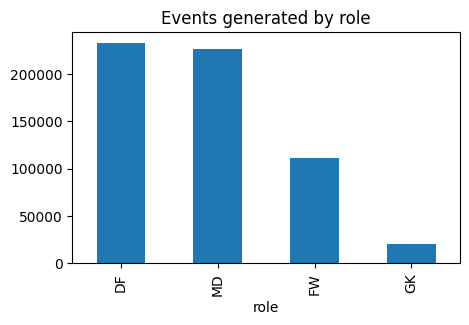

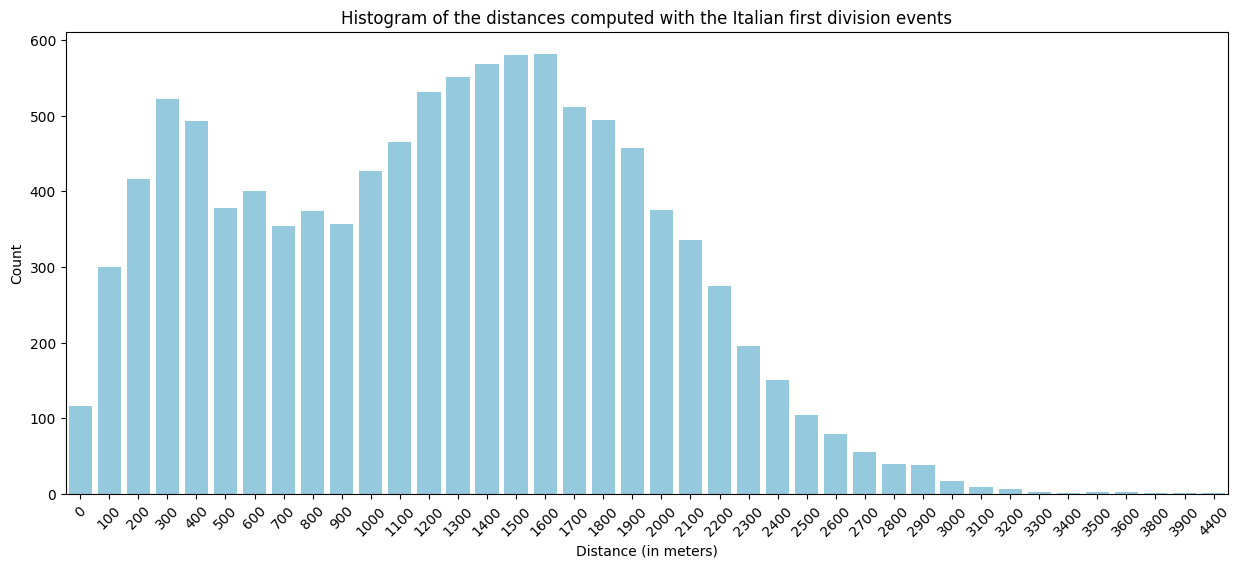

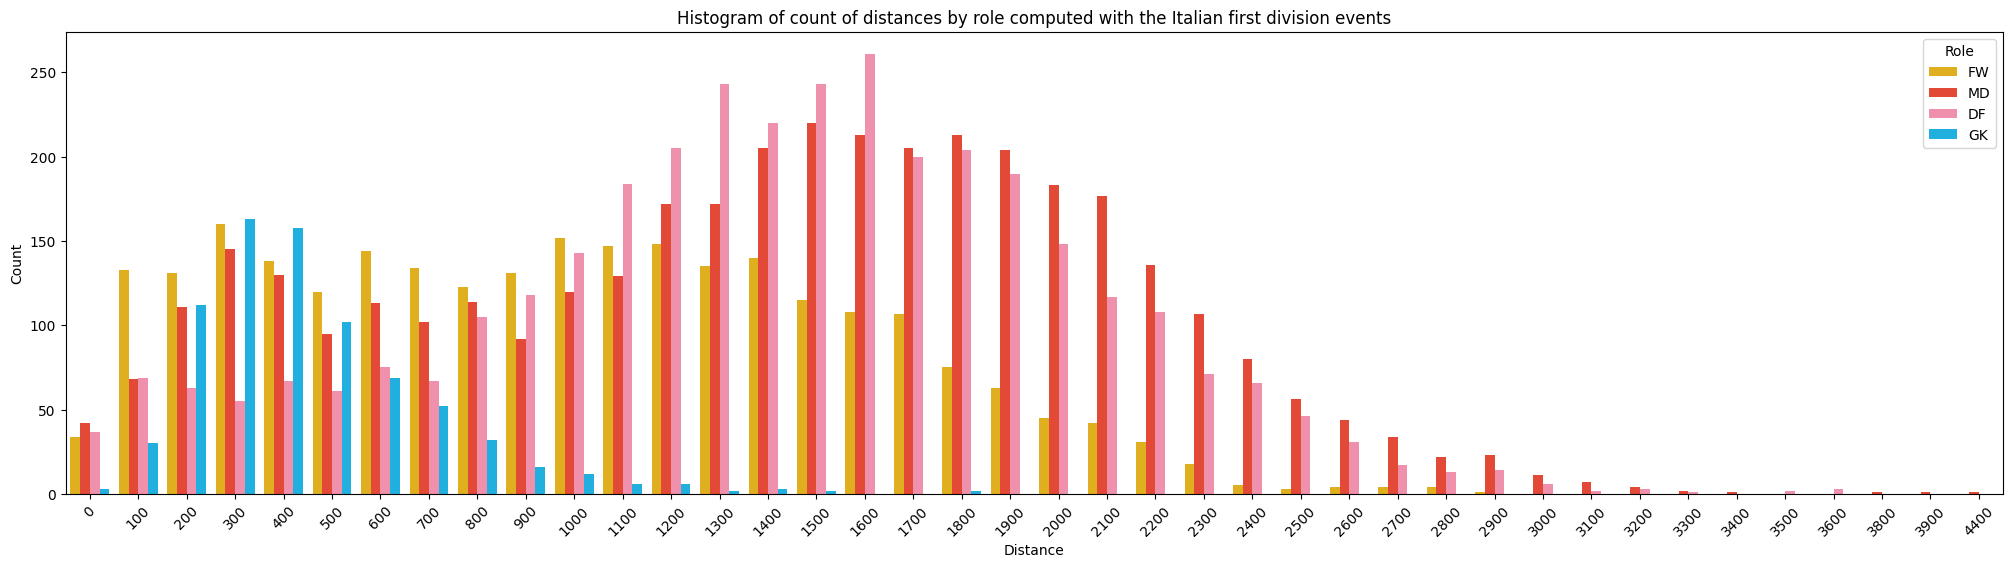

In [17]:
italian_events_df, df1, df2 = general_analysis('Italy', 'Italian first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for Italian first division


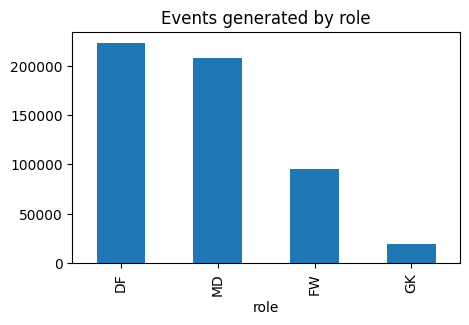

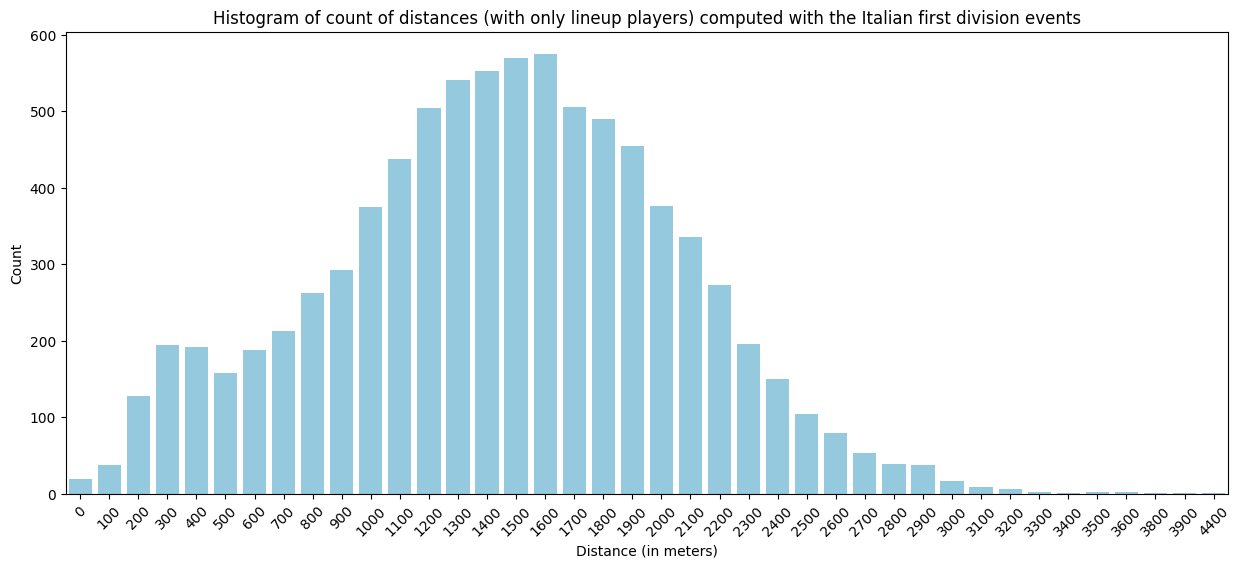

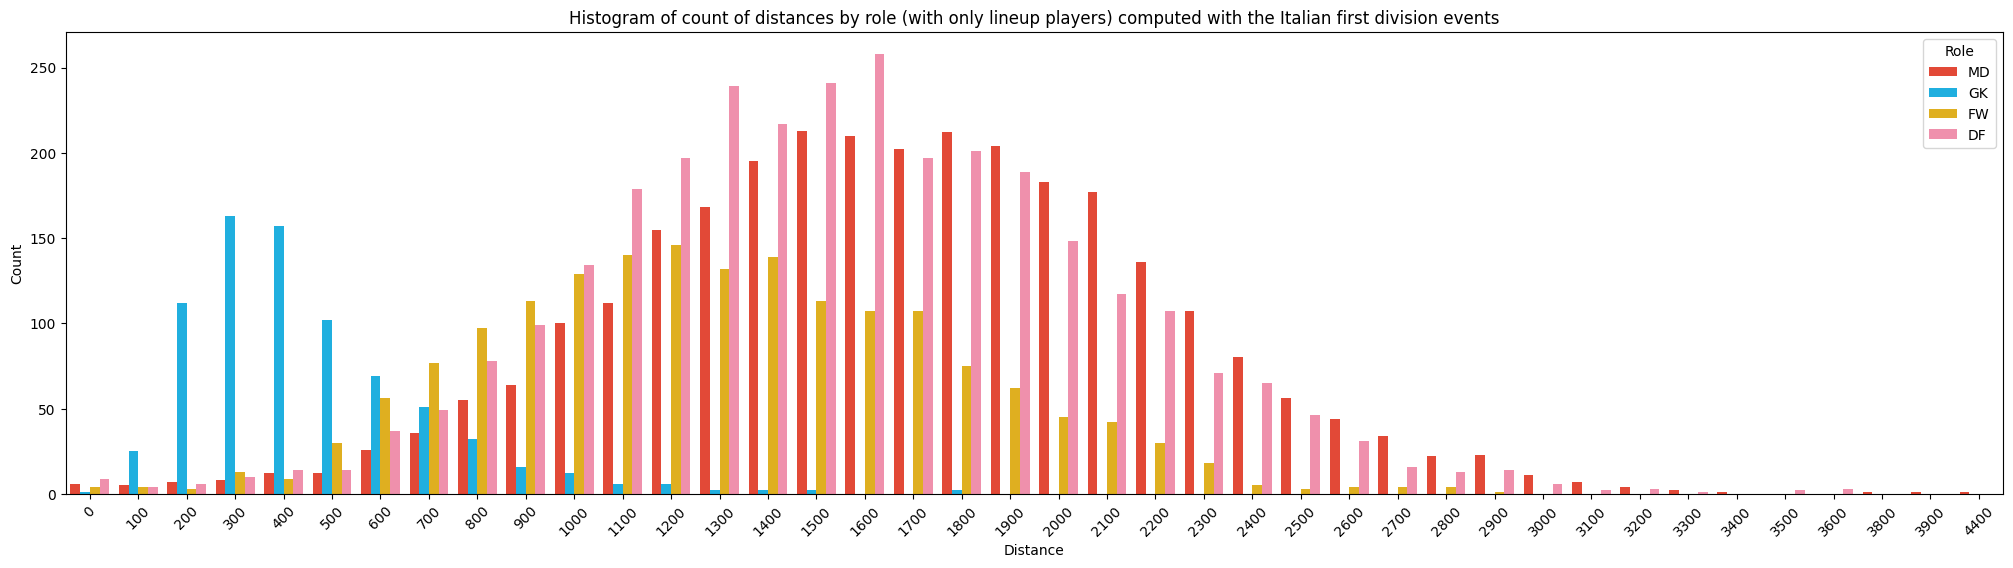

In [18]:
filtered_df, df1 = lineup_analysis(italian_events_df, 'Italy', 'Italian first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for Italian first division


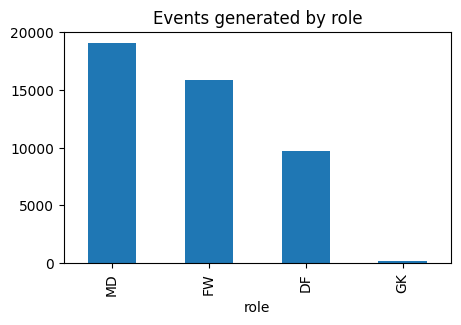

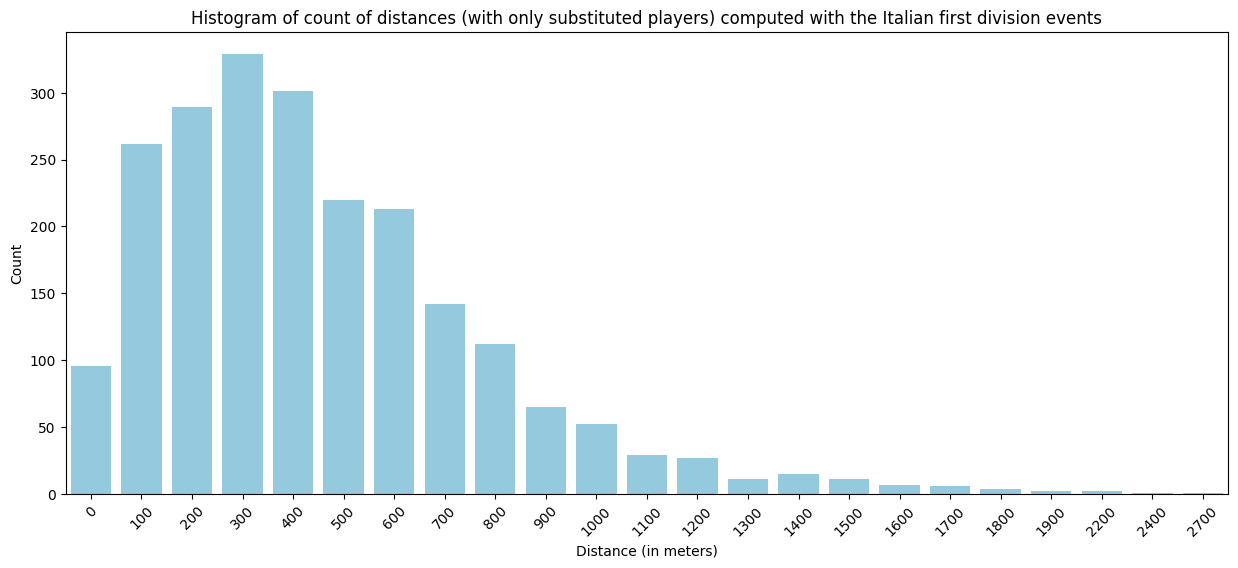

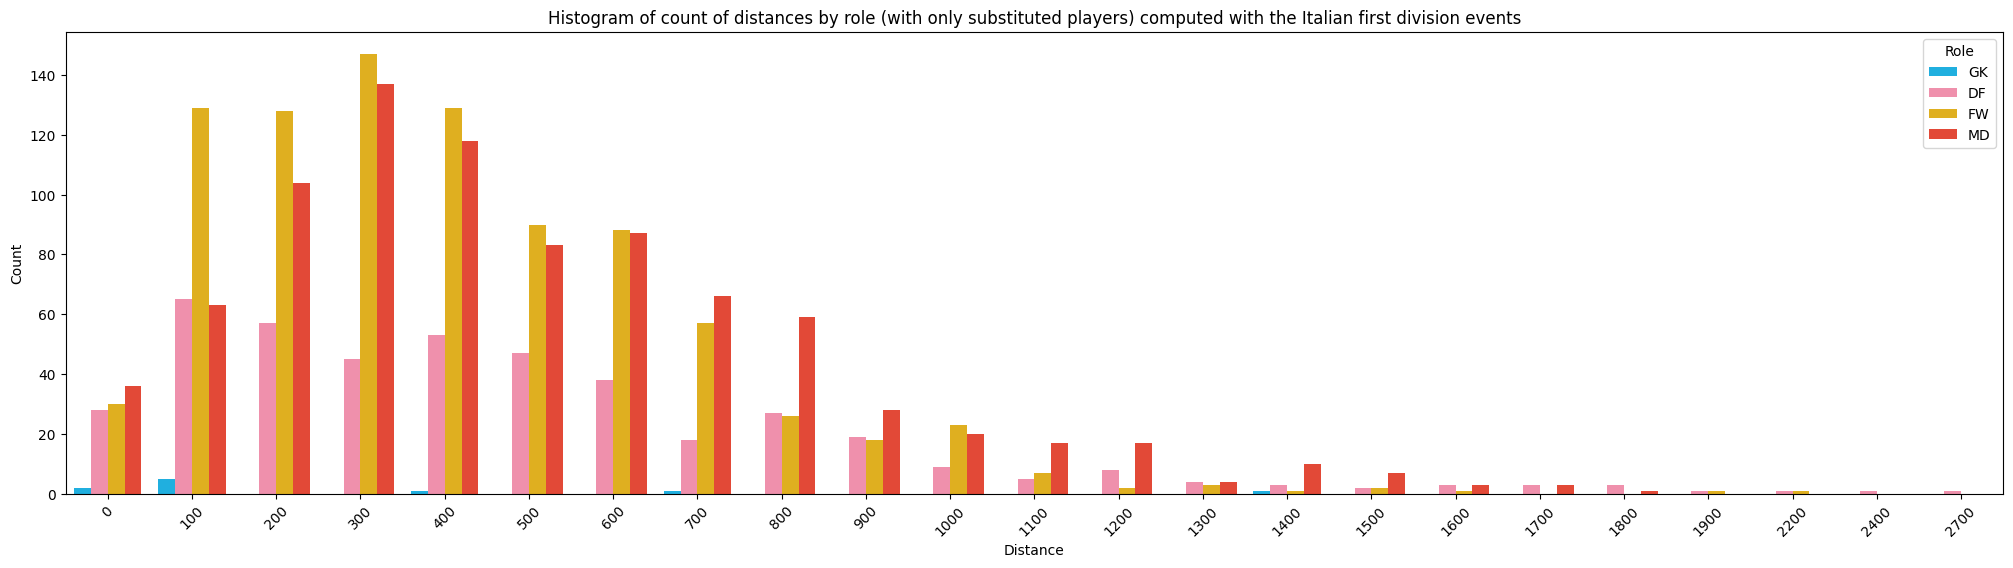

In [19]:
df1 = substitution_analysis(filtered_df, 'Italy', 'Italian first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## English first division analysis

The Premier League is known for its high-tempo and physical play. Matches are often intense and action-packed, with an emphasis on attacking flair and entertainment. It is also renowned for its physicality, with strong challenges and duels a common feature of games.

It is worth noting that, in total, the number of events generated by defenders and midfielders is almost equal. This is due to the physical nature of English football, which in turn leads to a higher number of recorded events, such as fouls, duels, and tackles.

General analysis for English first division


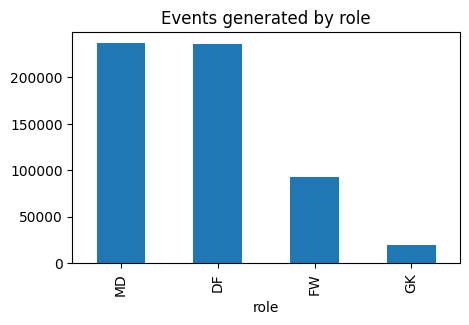

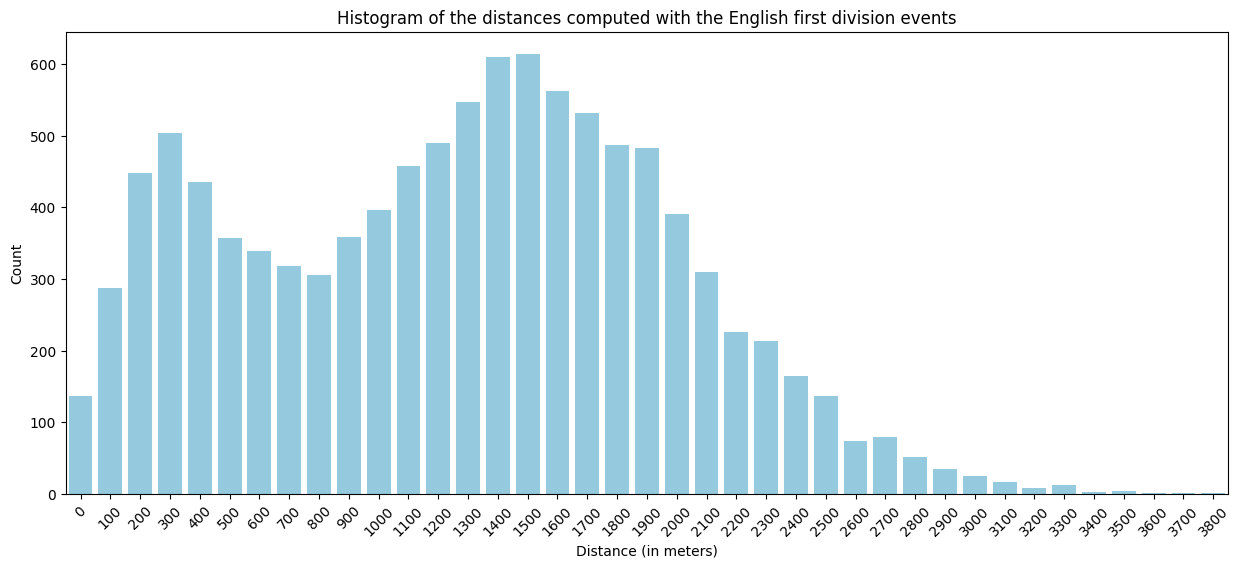

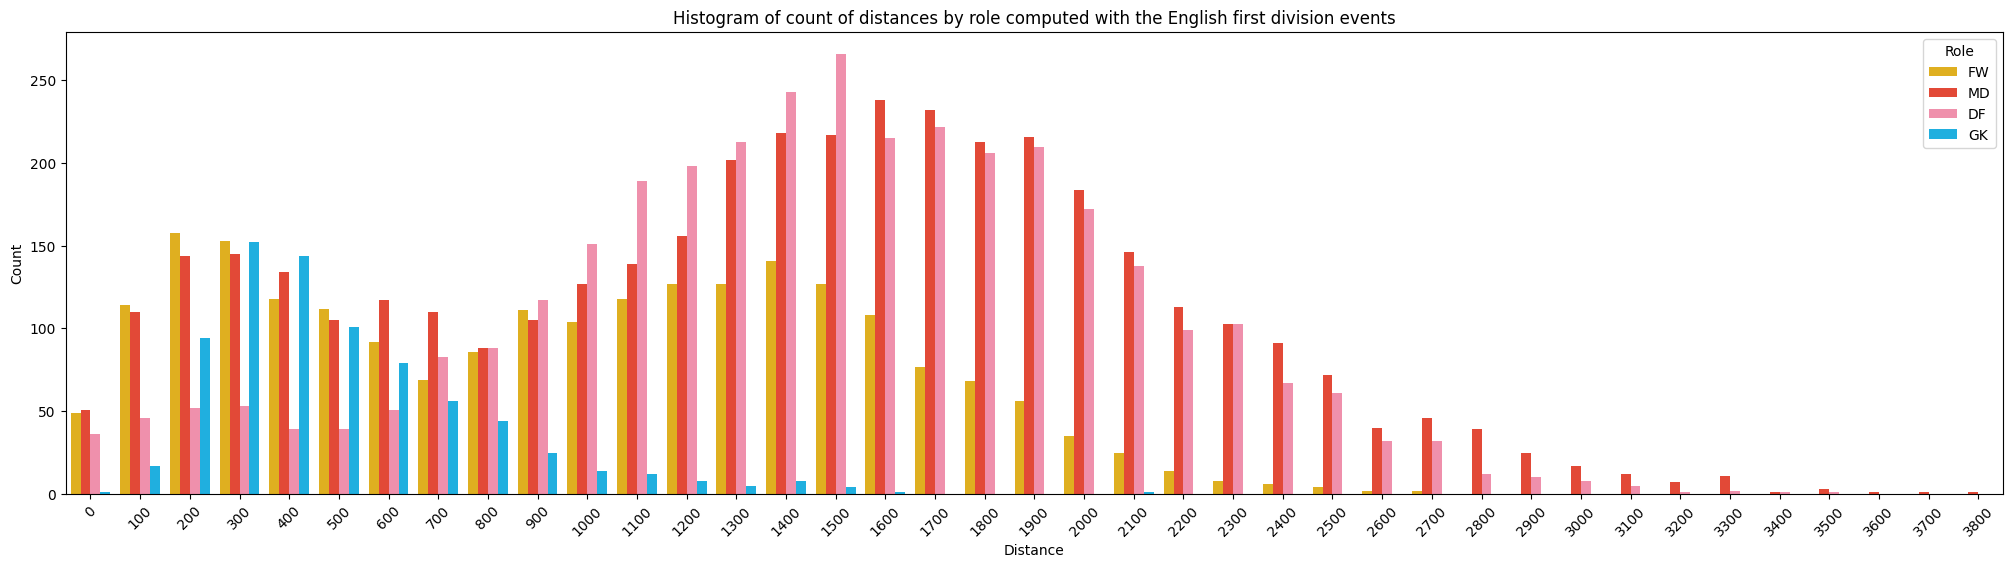

In [20]:
english_events_df, df1, df2 = general_analysis('England', 'English first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for English first division


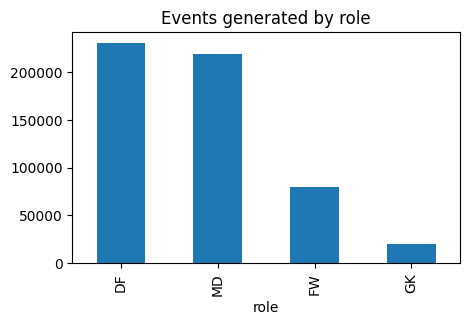

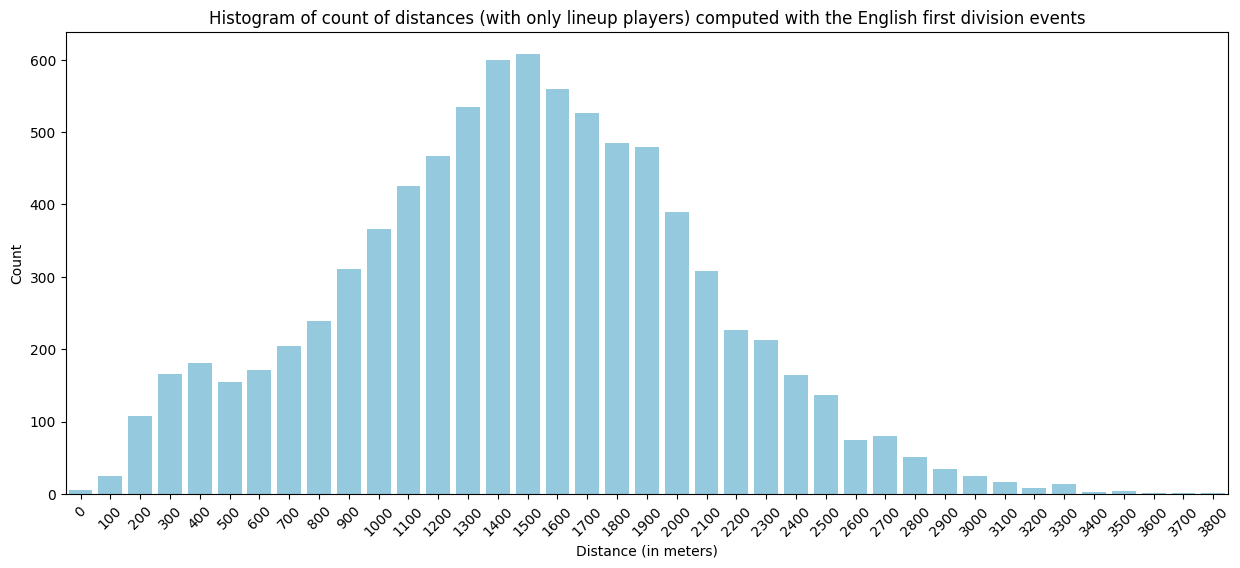

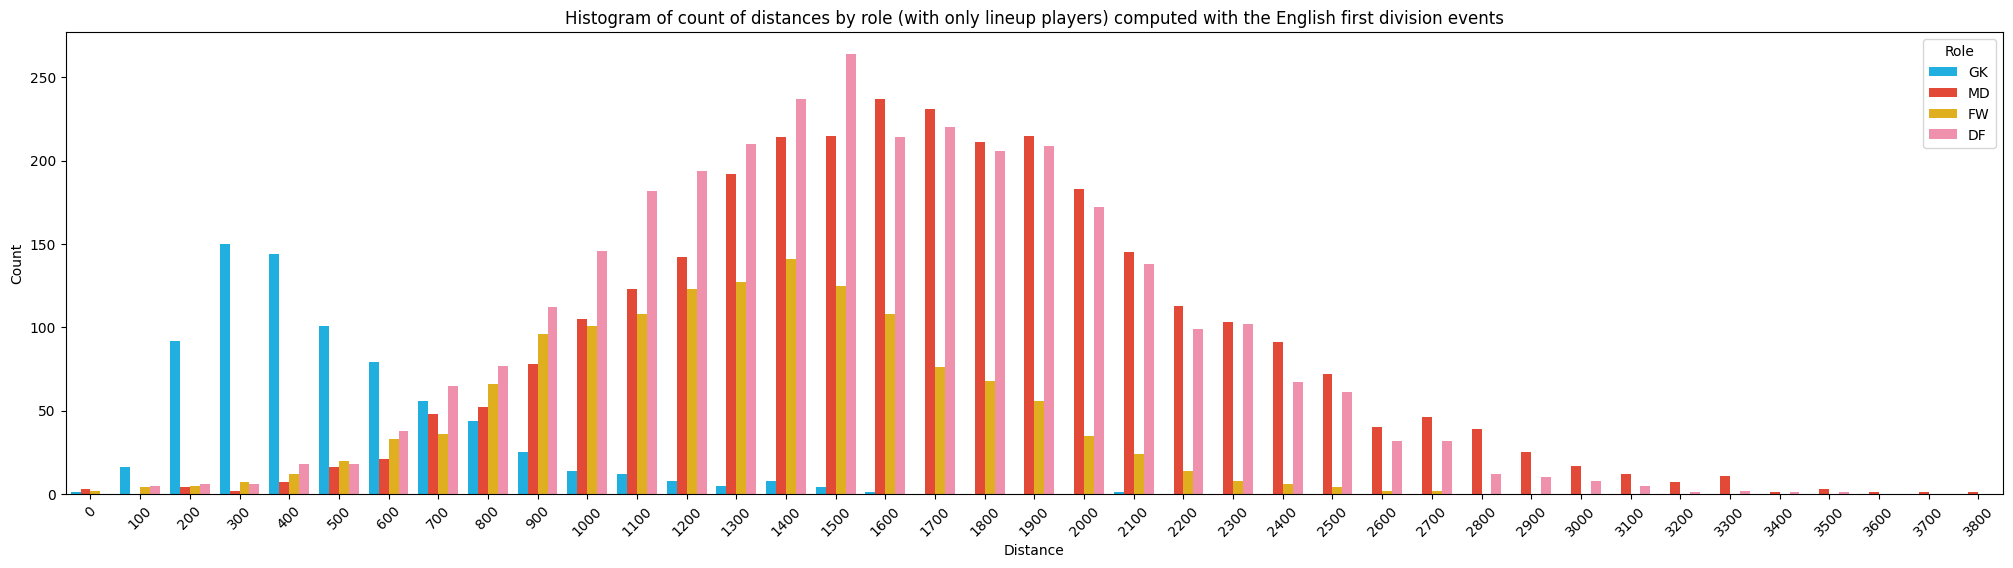

In [21]:
filtered_df, df1 = lineup_analysis(english_events_df, 'England', 'English first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for English first division


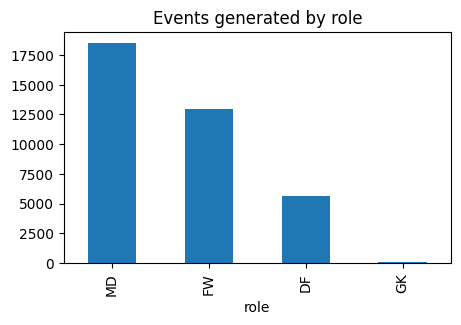

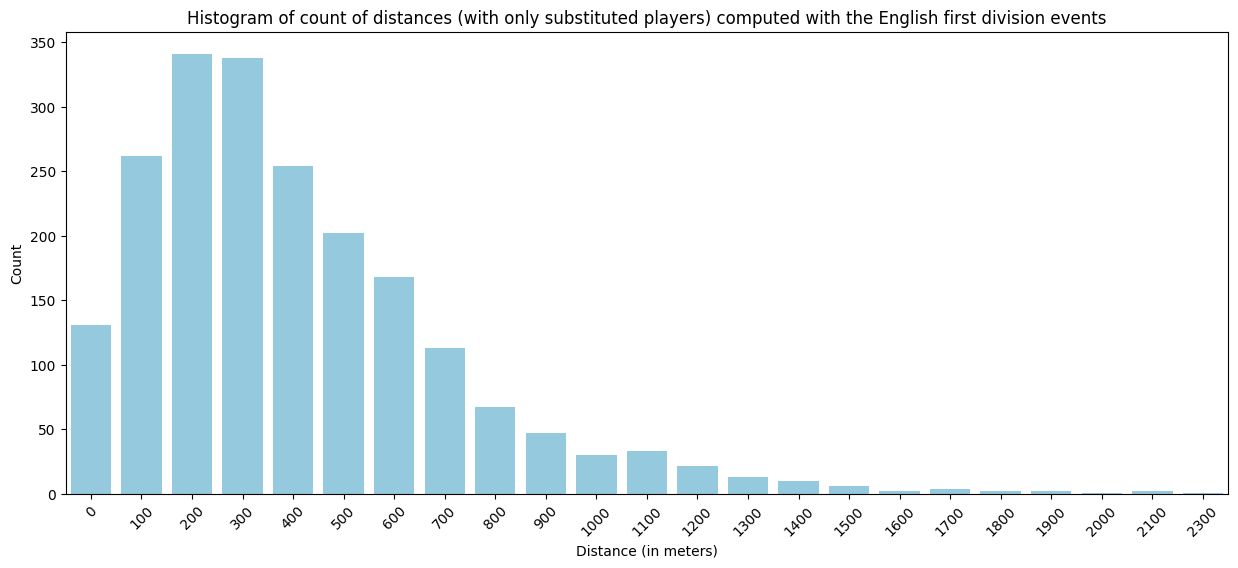

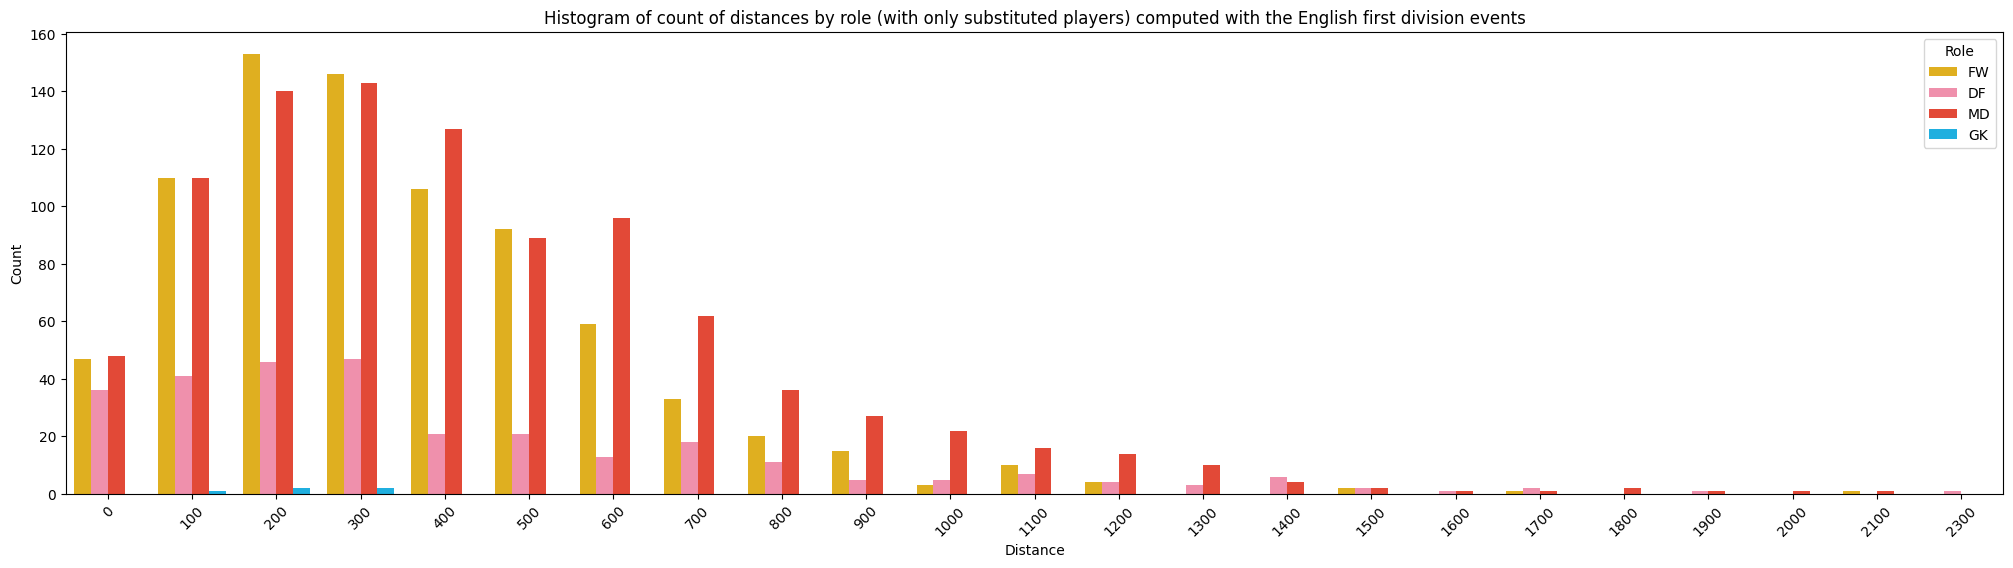

In [22]:
df1 = substitution_analysis(filtered_df, 'England', 'English first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## Spanish first division analysis

La Liga is known for its possession-based, passing game and attacking flair. Spanish teams are adept at keeping possession and building attacks through quick passing movements. This is also evident from the fact that, unlike all other leagues analyzed, the number of events generated by midfielders is higher than that of defenders.

General analysis for Spanish first division


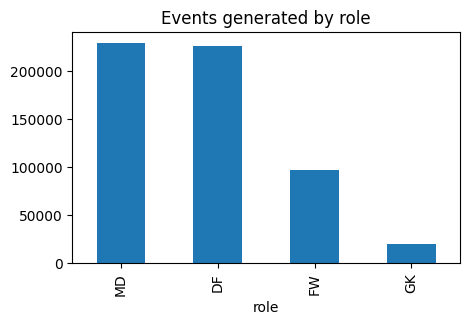

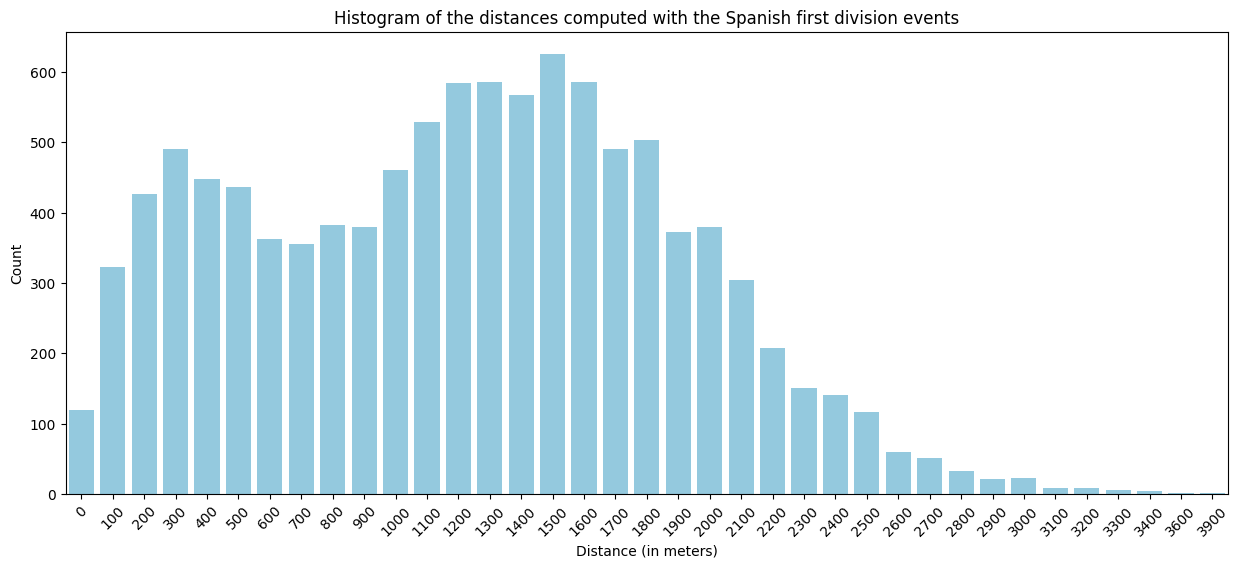

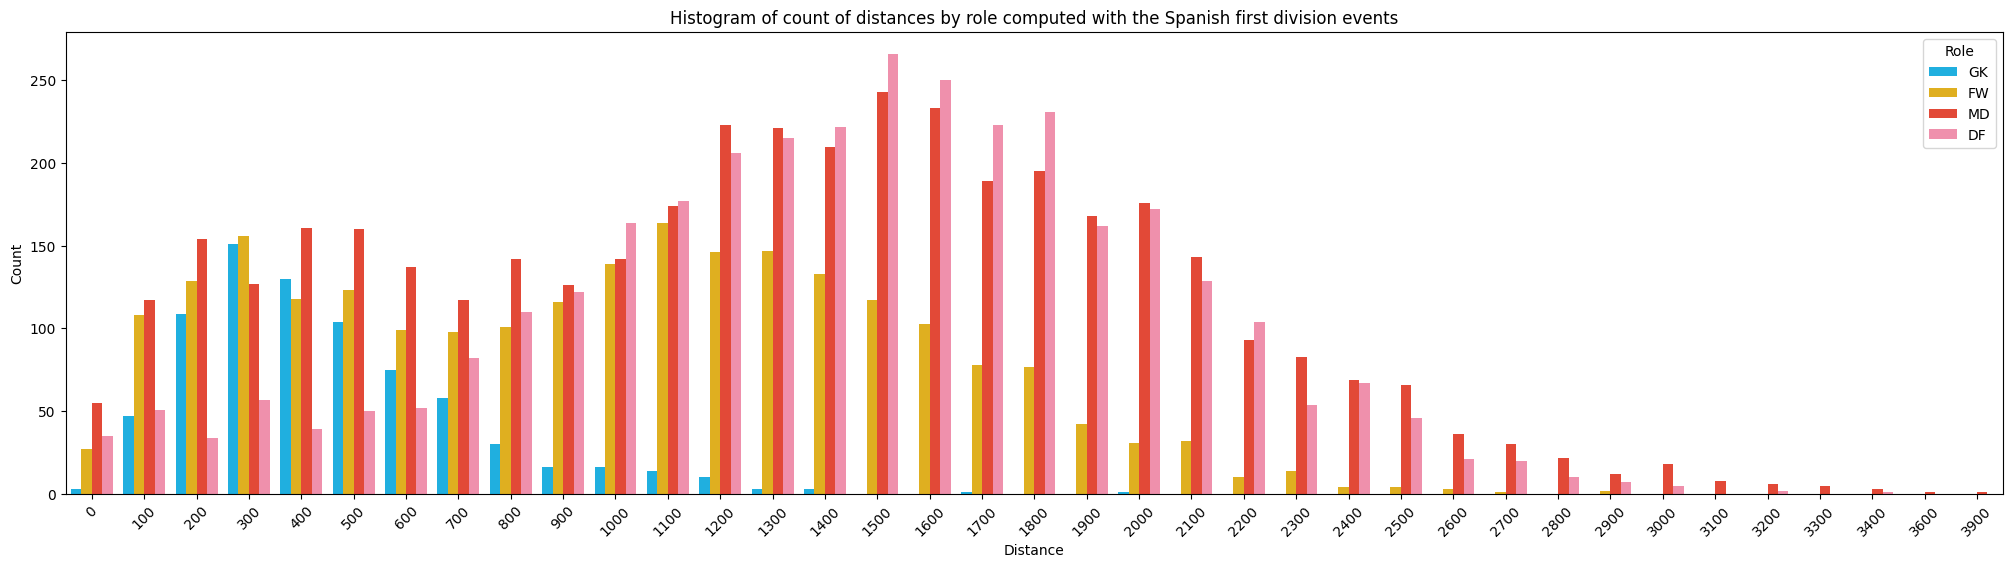

In [23]:
spanish_events_df, df1, df2 = general_analysis('Spain', 'Spanish first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for Spanish first division


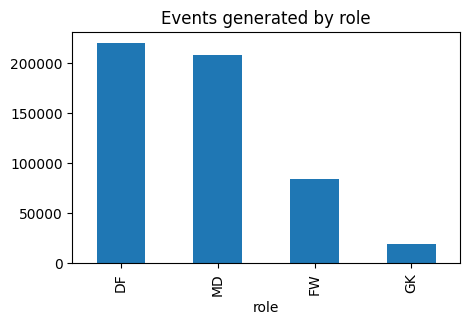

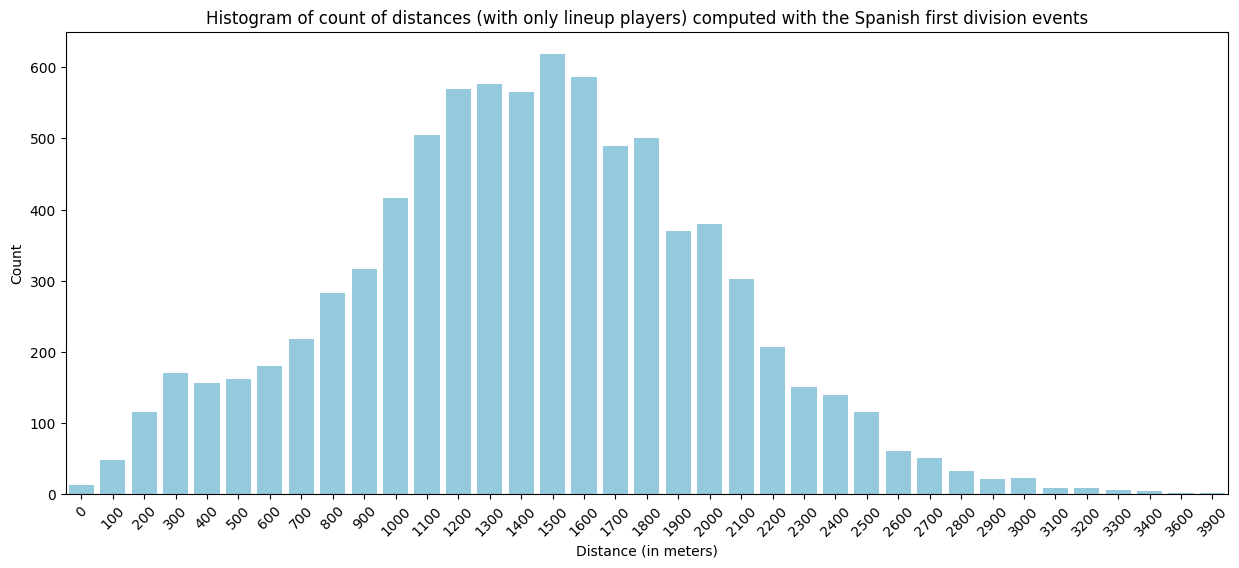

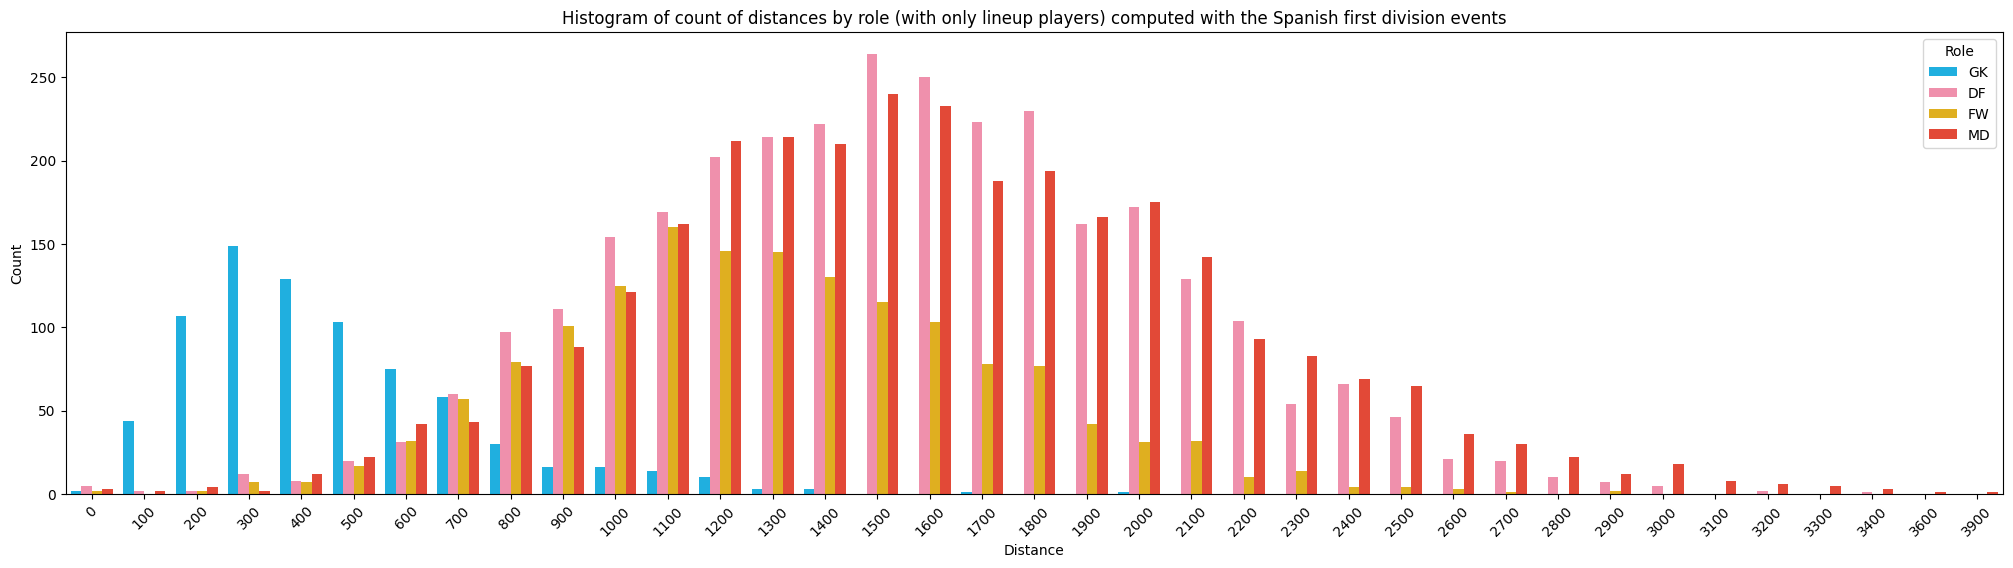

In [24]:
filtered_df, df1 = lineup_analysis(spanish_events_df, 'Spain', 'Spanish first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for Spanish first division


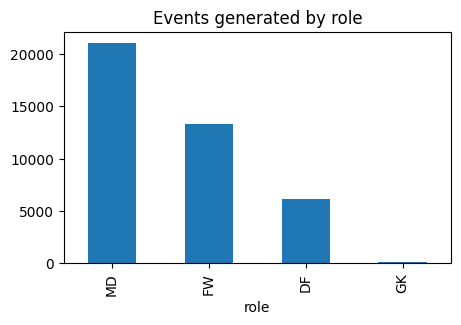

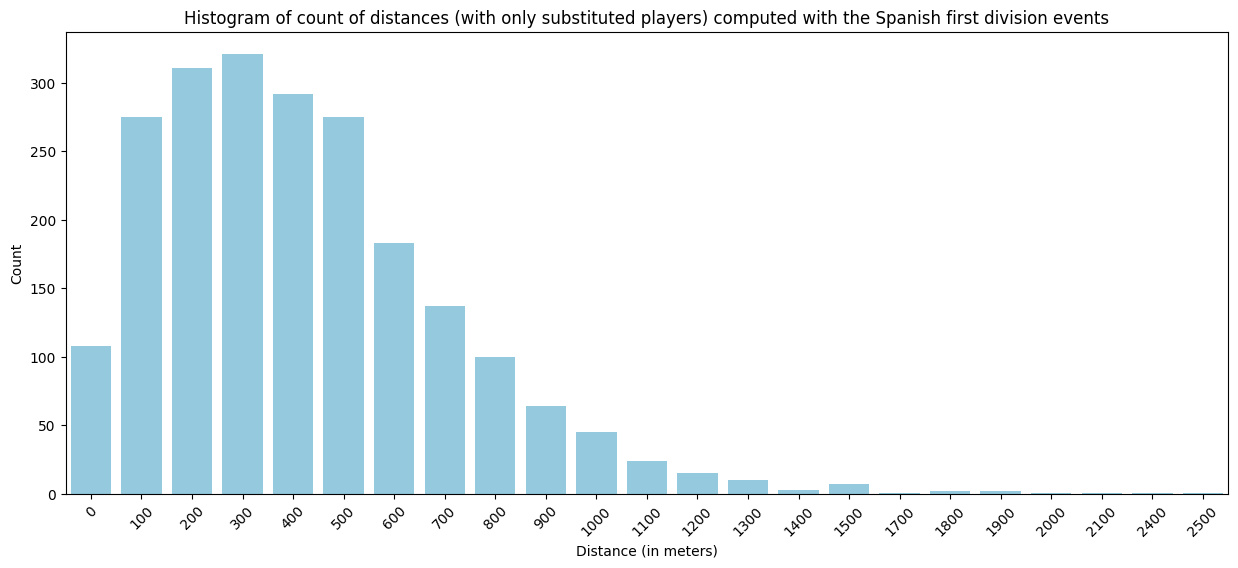

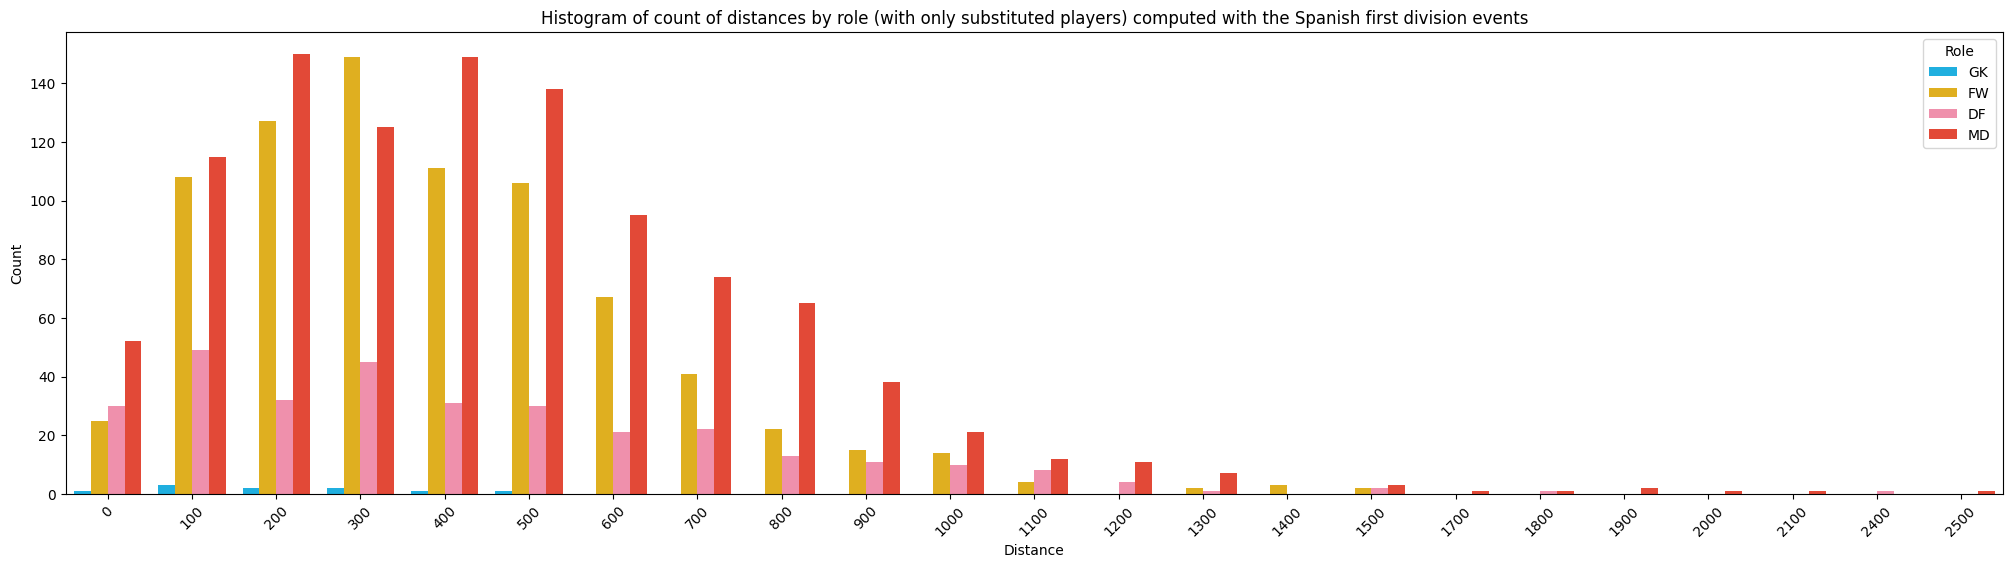

In [25]:
df1 = substitution_analysis(filtered_df, 'Spain', 'Spanish first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## German first division analysis

It is worth noting that the longest distance covered by a player in the analyzed leagues is 4400 meters, present only in the Italian and German first divisions and in the World Cup. As for the league under consideration, this is probably due to the fact that German football matches have a greater emphasis on pressing and fast transitions.

General analysis for German first division


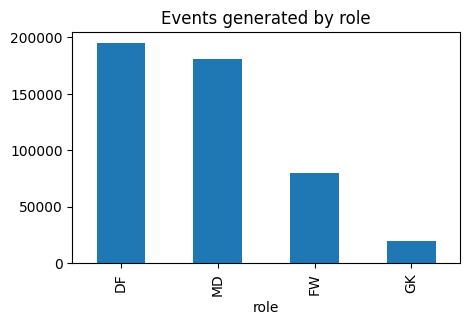

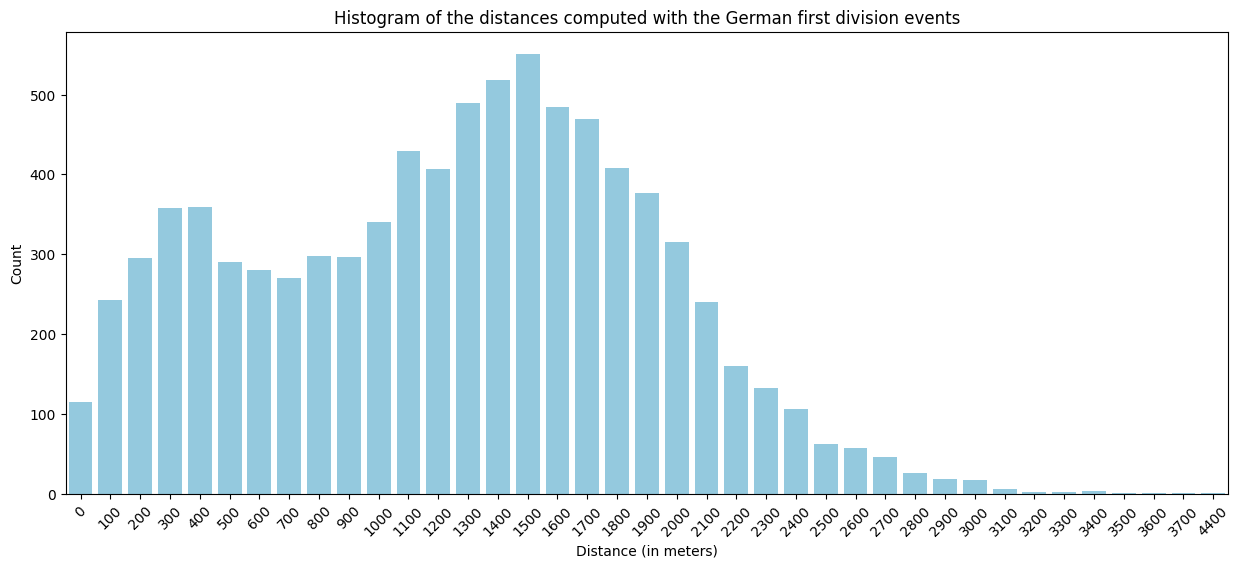

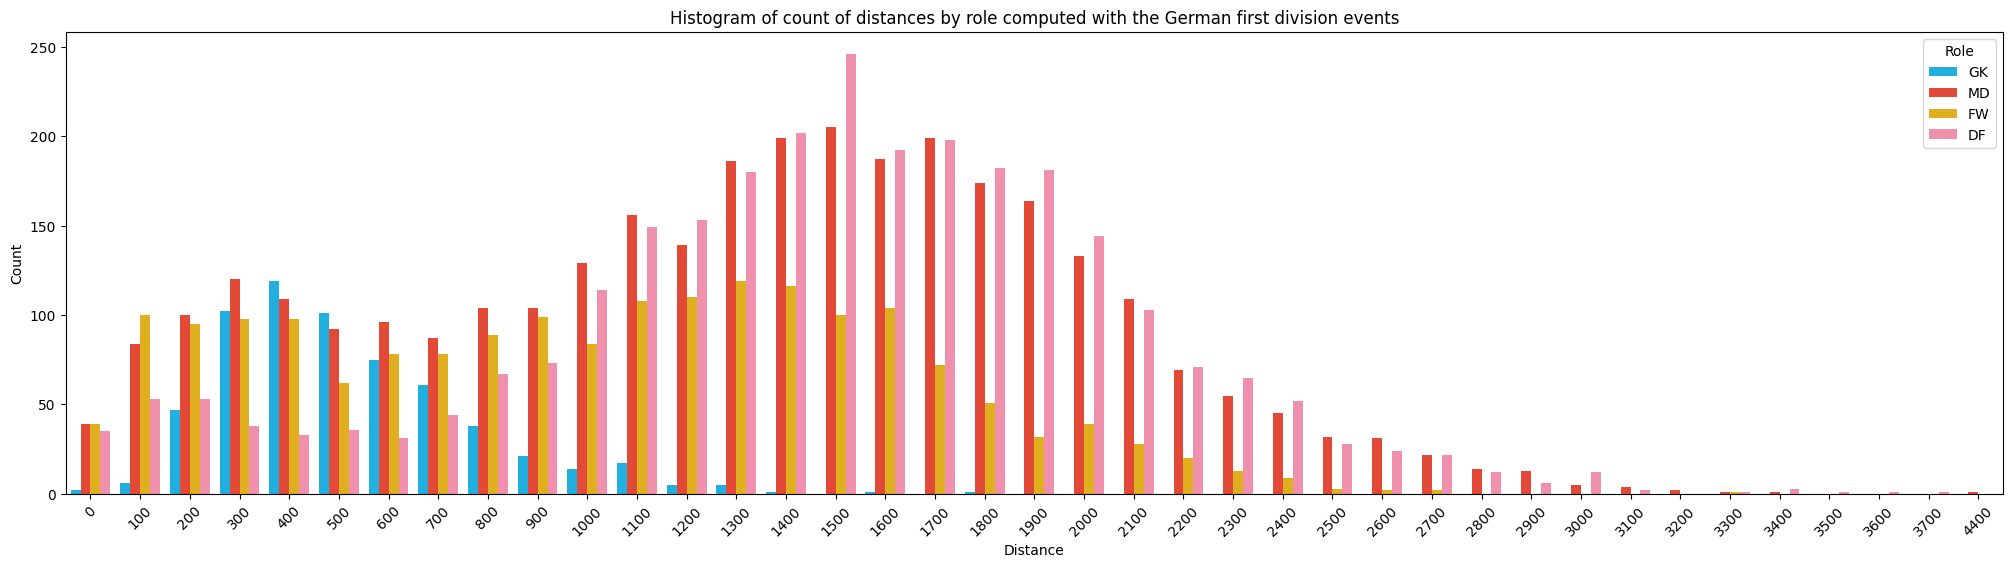

In [26]:
german_events_df, df1, df2 = general_analysis('Germany', 'German first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for German first division


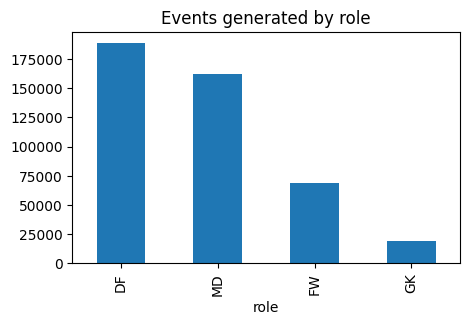

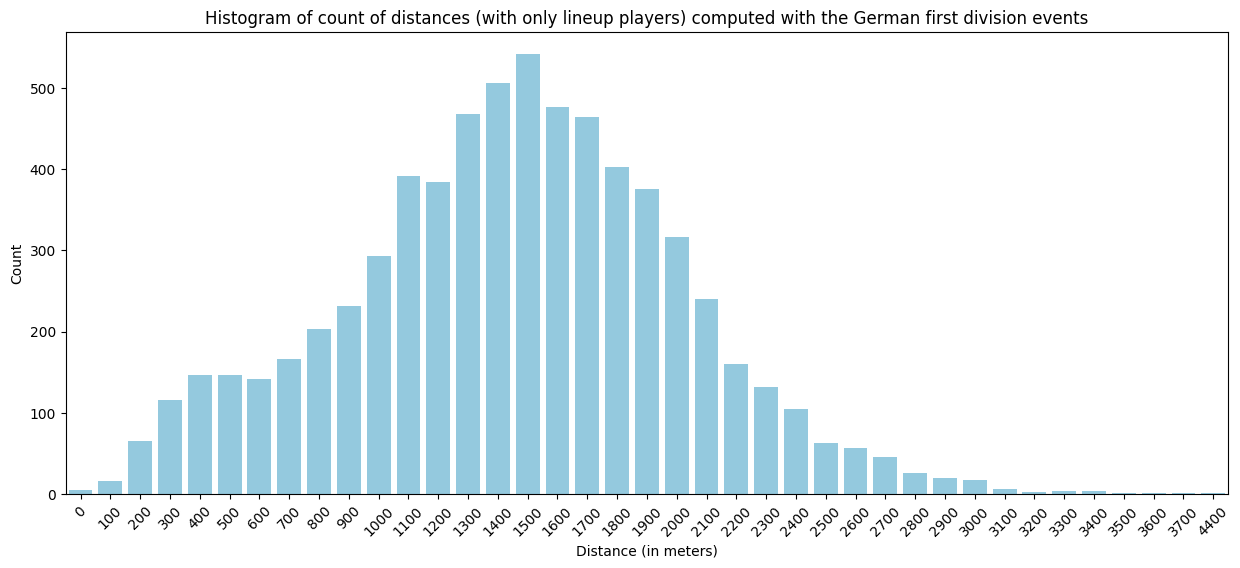

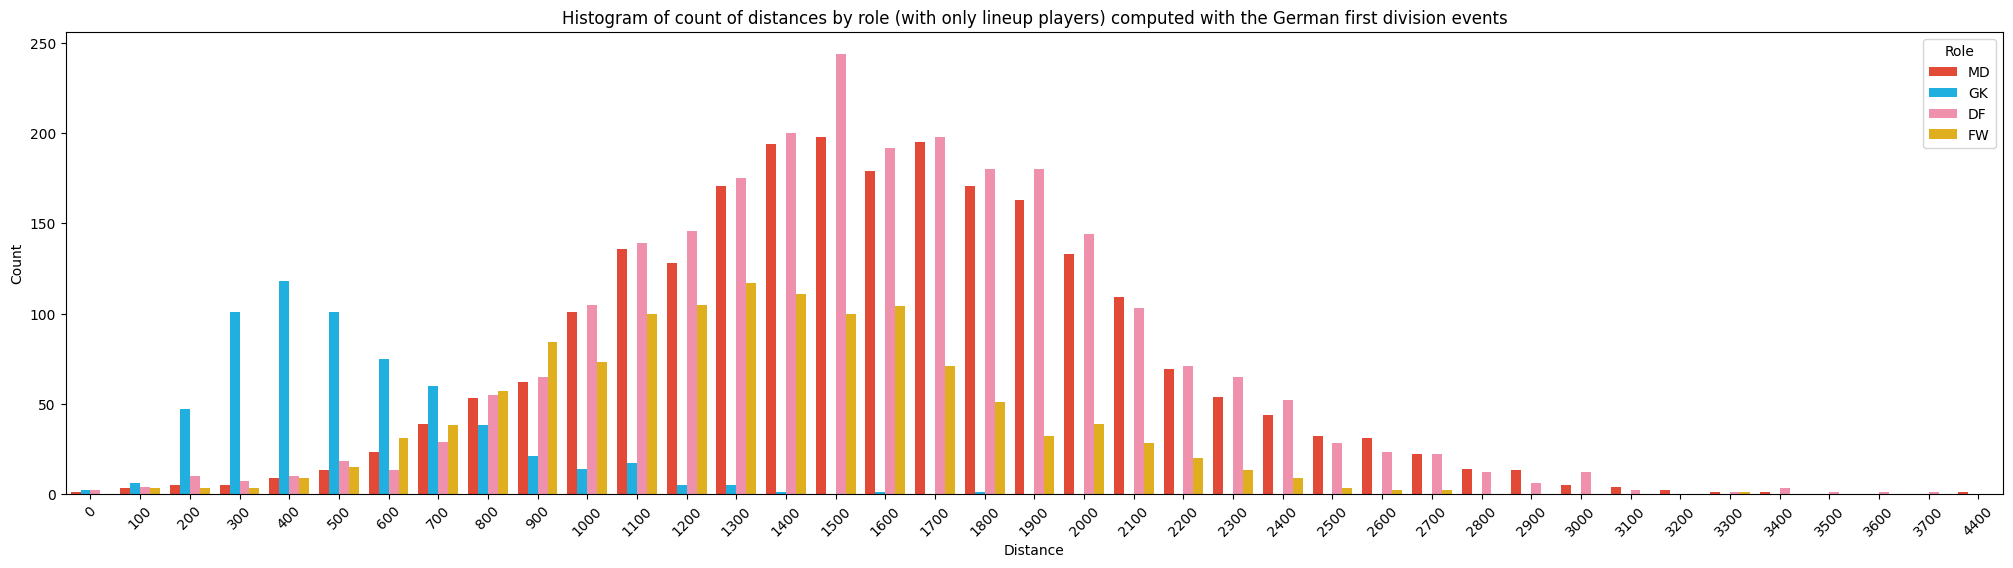

In [27]:
filtered_df, df1 = lineup_analysis(german_events_df, 'Germany', 'German first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for German first division


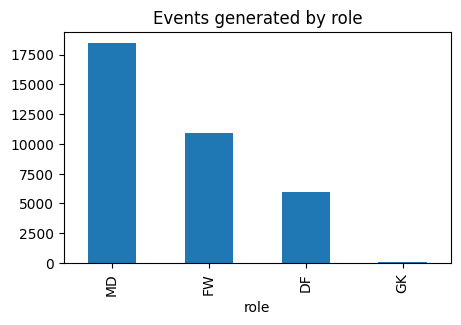

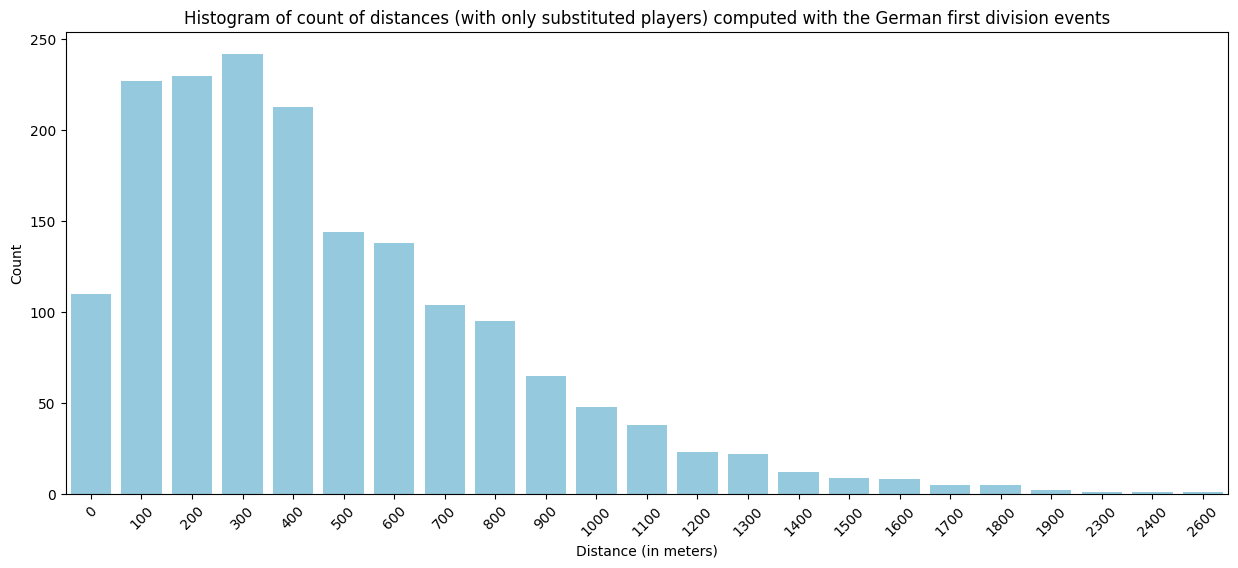

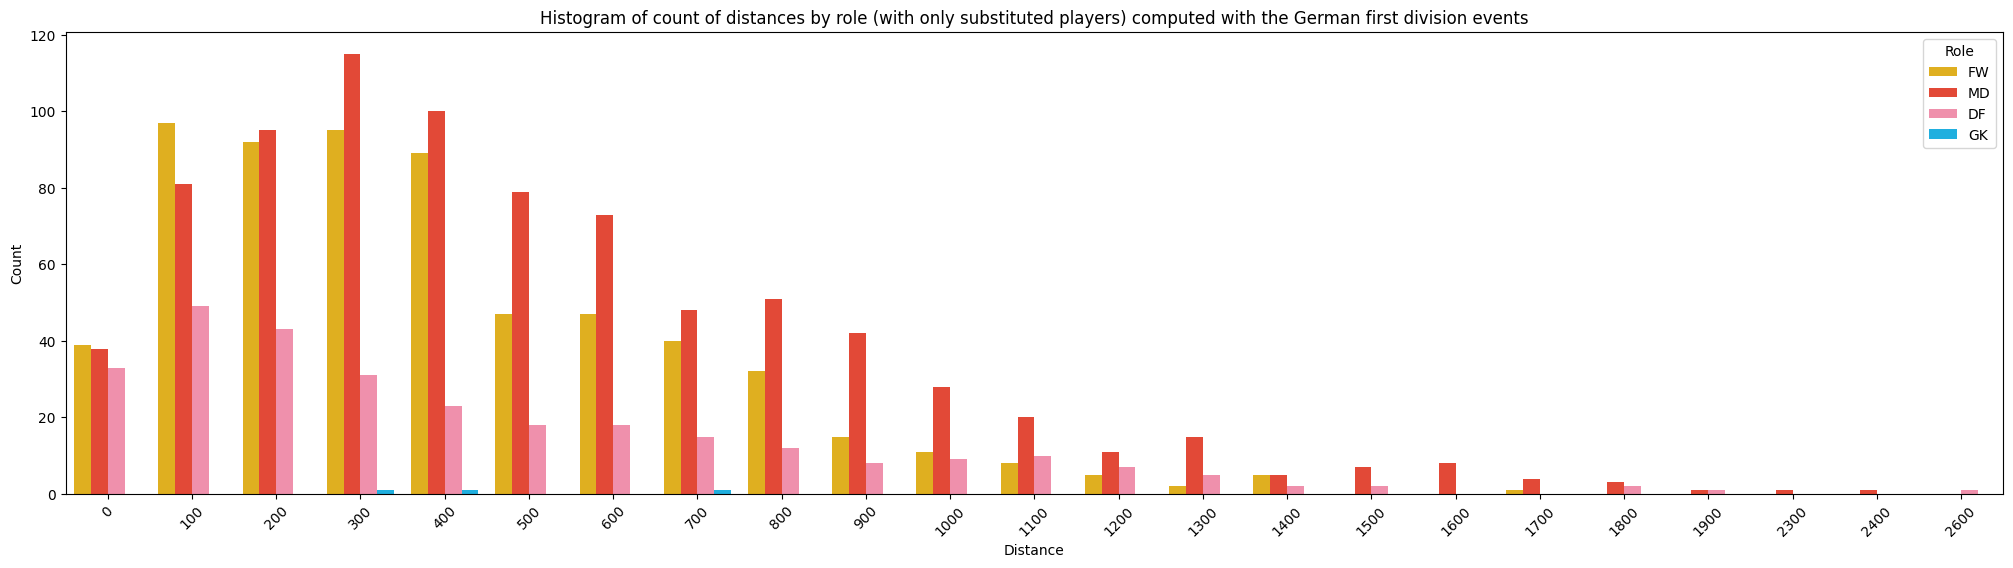

In [28]:
df1 = substitution_analysis(filtered_df, 'Germany', 'German first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## French first division analysis

Although Ligue 1 can be tactically diverse, French teams are often known for a more open and attacking style of play compared to other European leagues. The results obtained and visible in the following graphs are also largely in line with the graphs of the previous leagues already shown.

General analysis for French first division


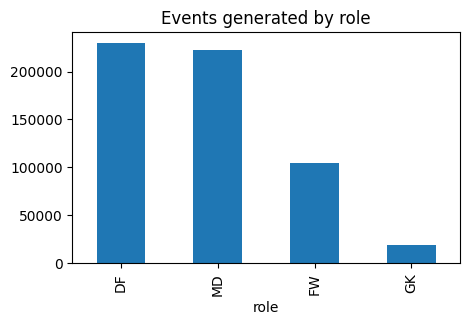

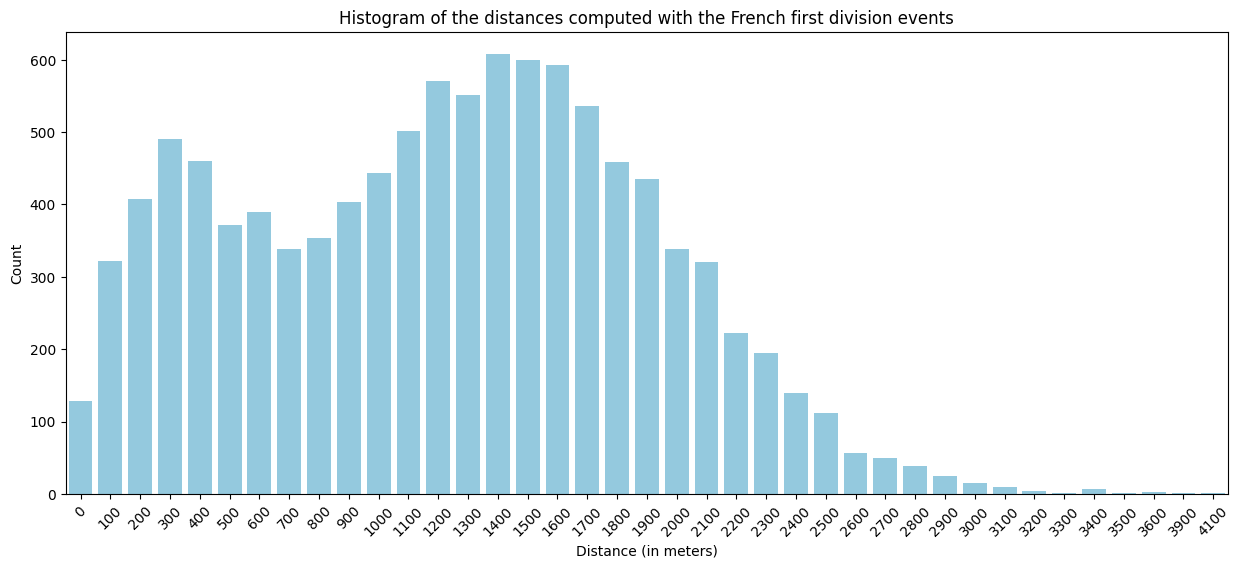

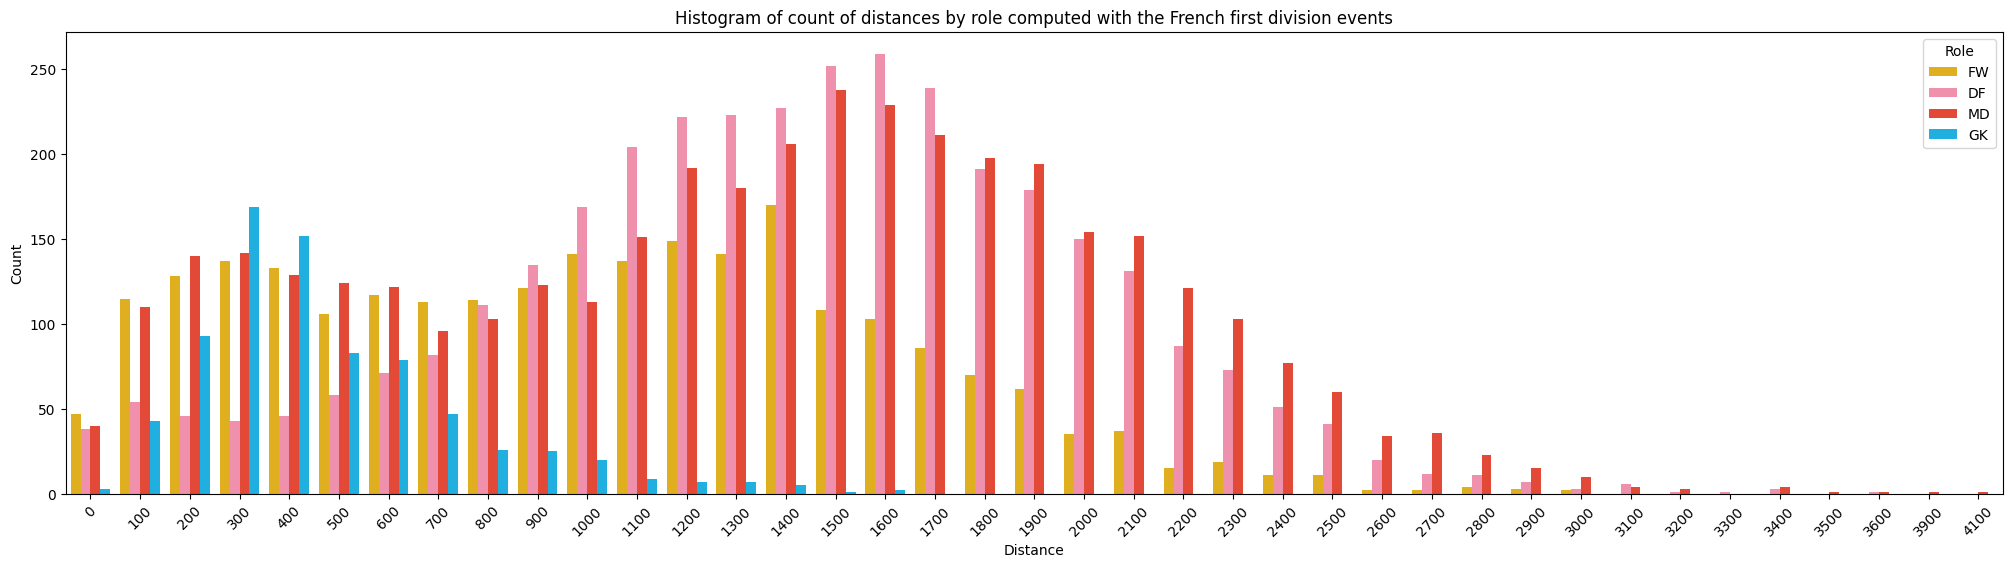

In [29]:
french_events_df, df1, df2 = general_analysis('France', 'French first division')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for French first division


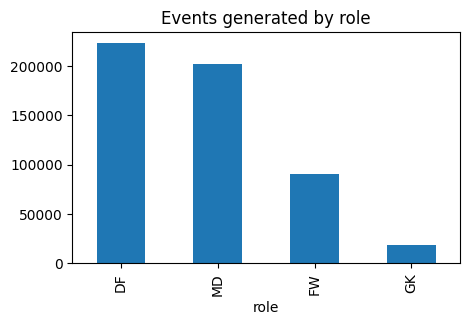

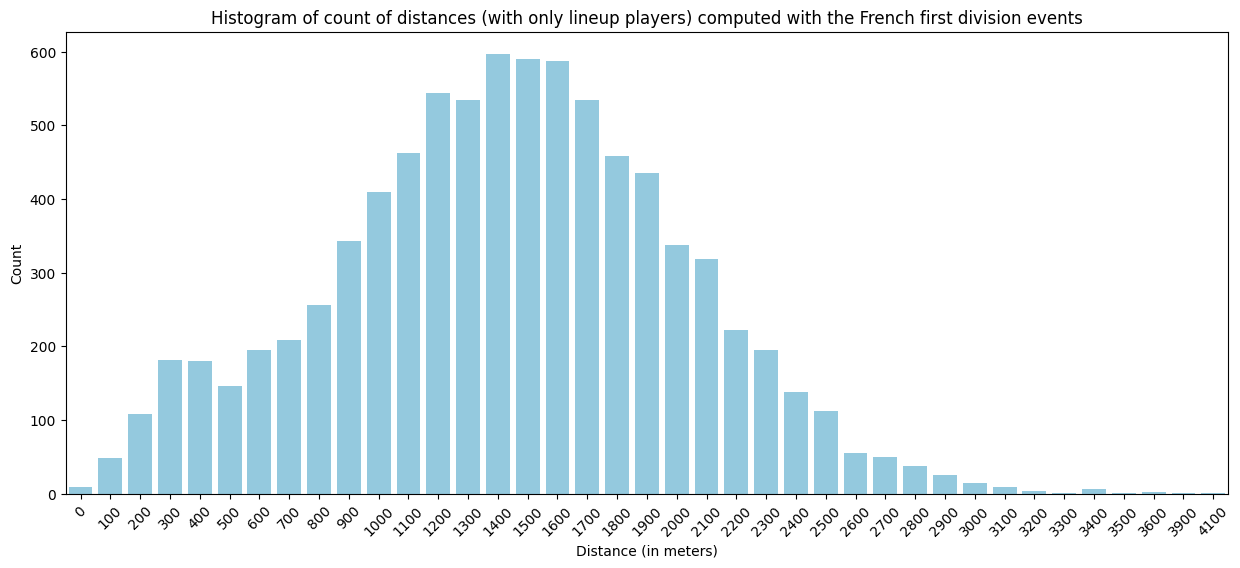

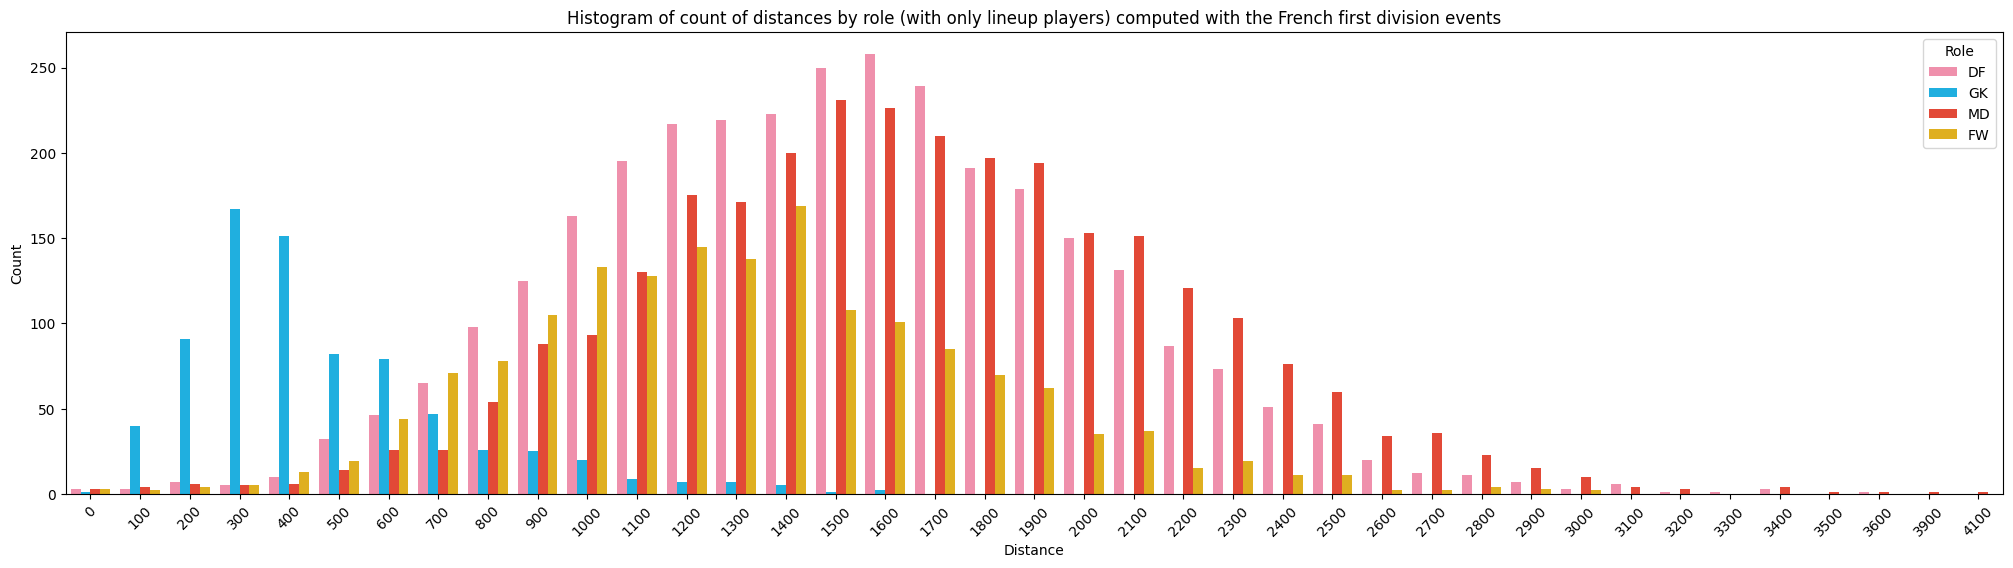

In [30]:
filtered_df, df1 = lineup_analysis(french_events_df, 'France', 'French first division')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for French first division


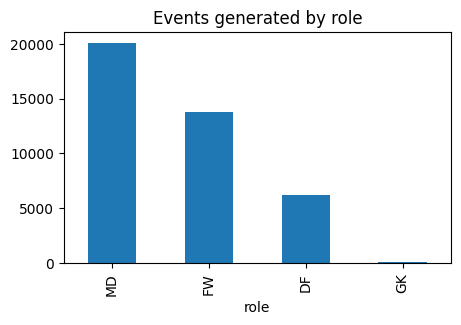

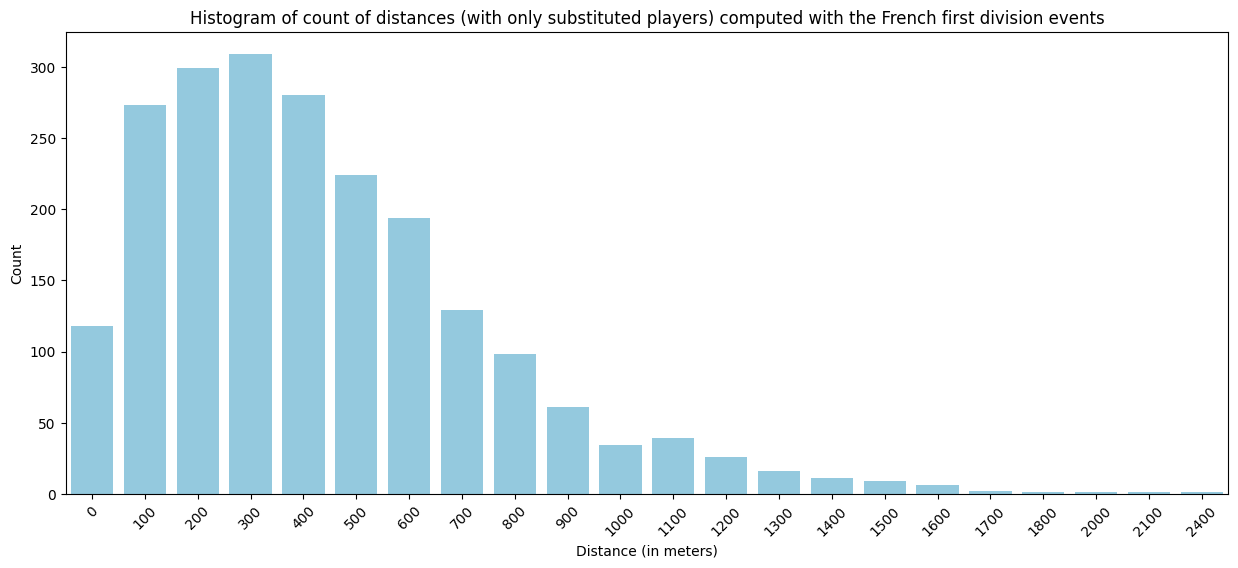

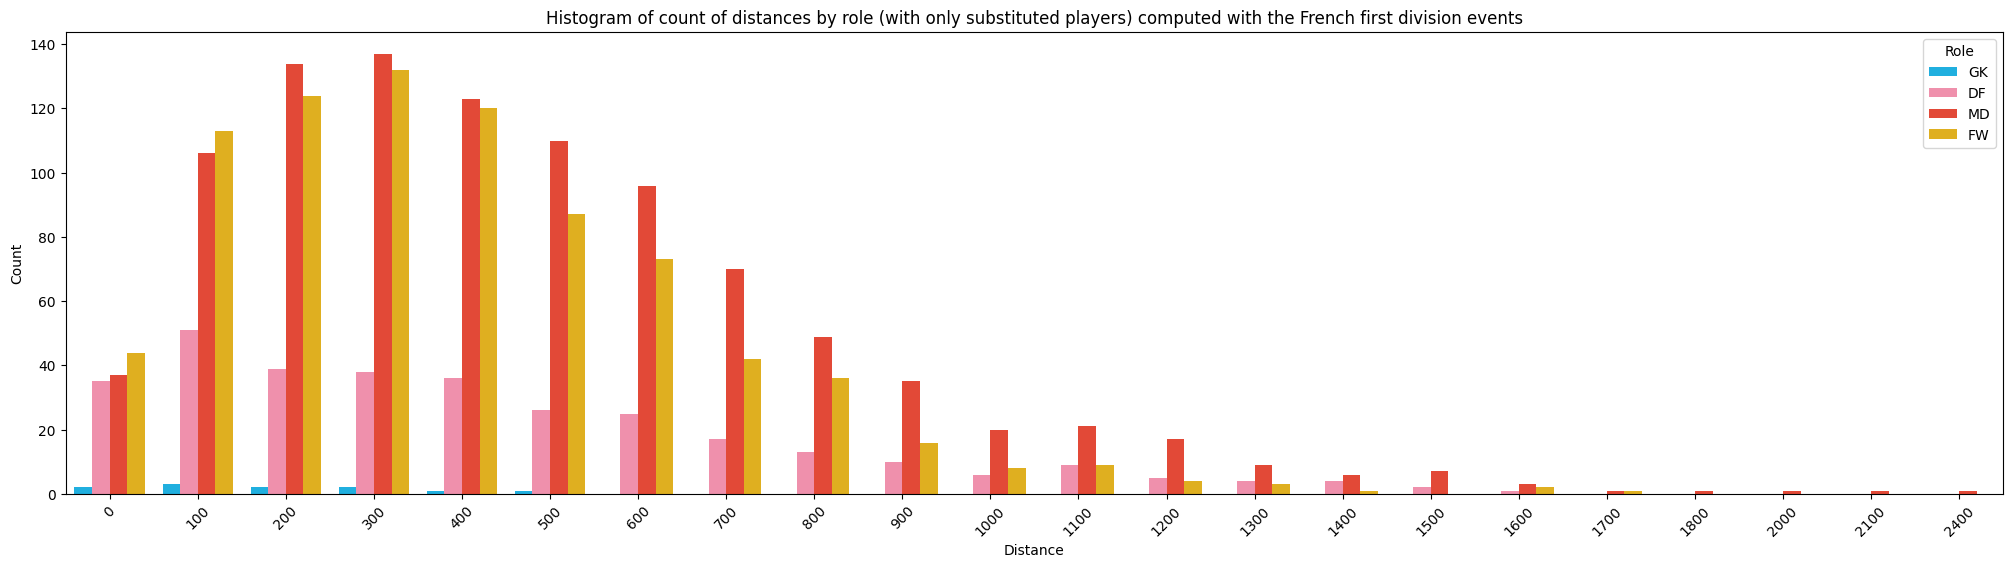

In [31]:
df1 = substitution_analysis(filtered_df, 'France', 'French first division')

substitution_players_df = pd.concat([substitution_players_df, df1])

## European Championship

In both the European Championship and the World Cup, the Gaussian distributions visible in previous leagues are much less visible. This is mainly due to the fact that there are fewer games played in a cup competition. However, it is also important to note that the maximum distance covered in the European Championship is only 3200 meters, the lowest value recorded in this analysis. This suggests that players tend to move less during international matches, or that the matches are very clean and therefore do not generate many events that map the players' paths relatively accurately.

General analysis for European Championship


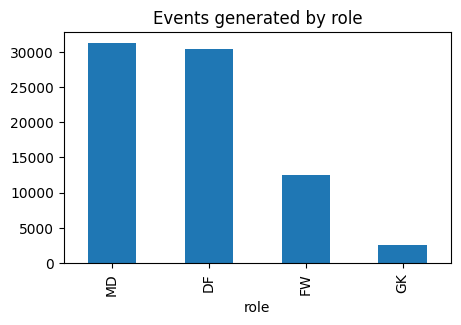

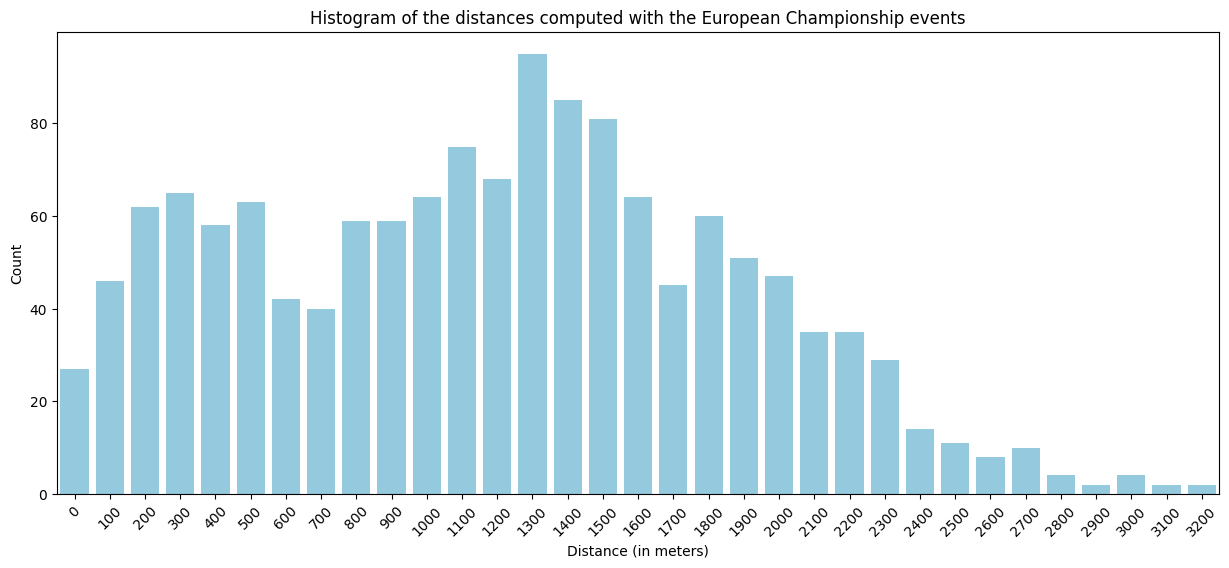

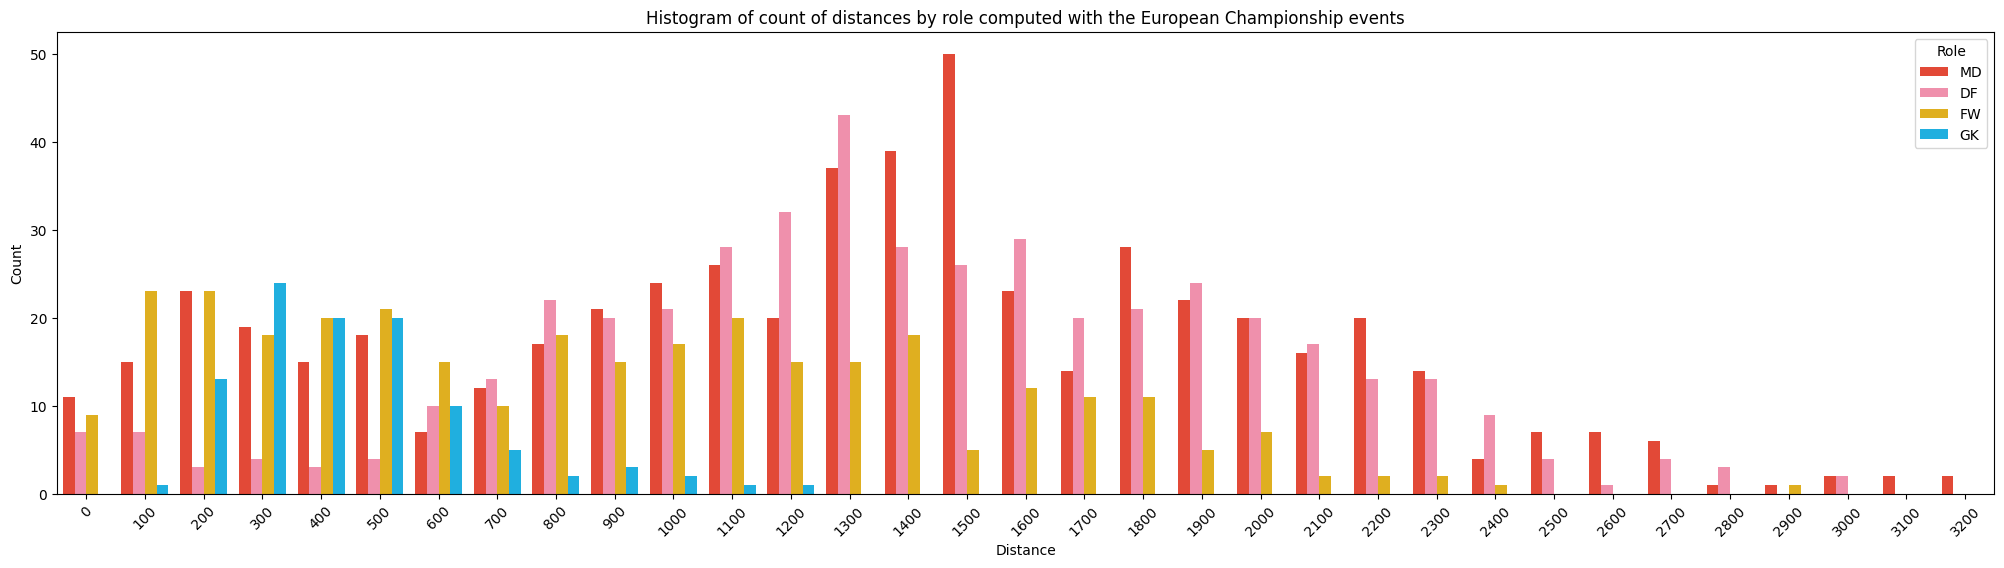

In [32]:
european_events_df, df1, df2 = general_analysis('European_Championship', 'European Championship')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for European Championship


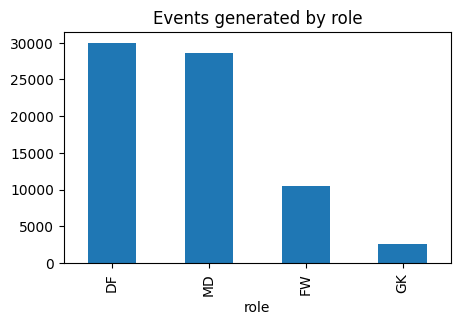

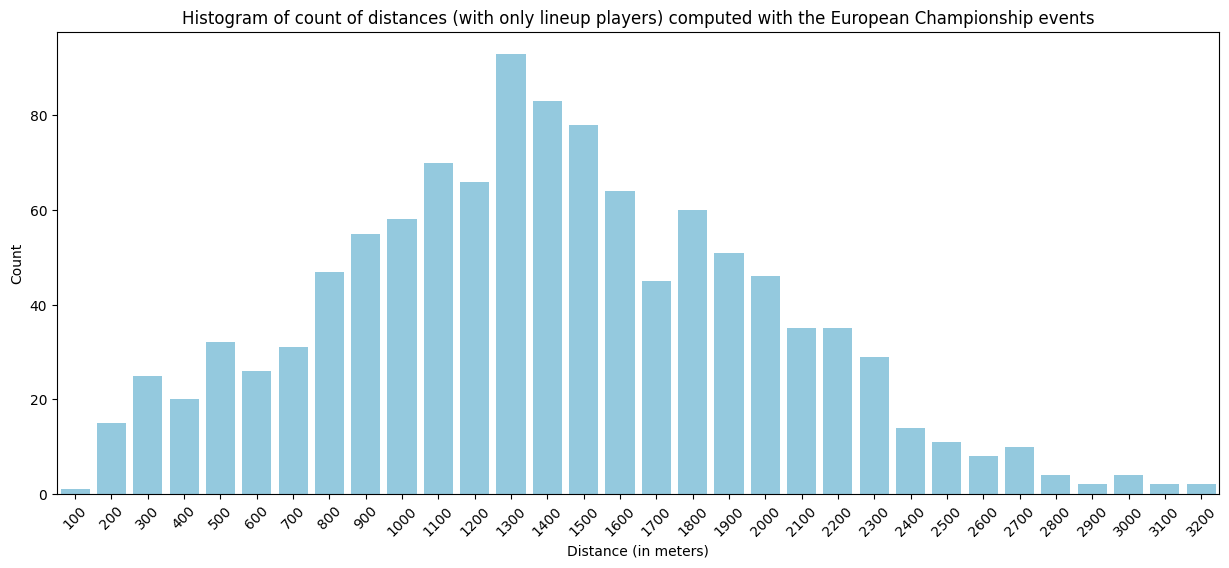

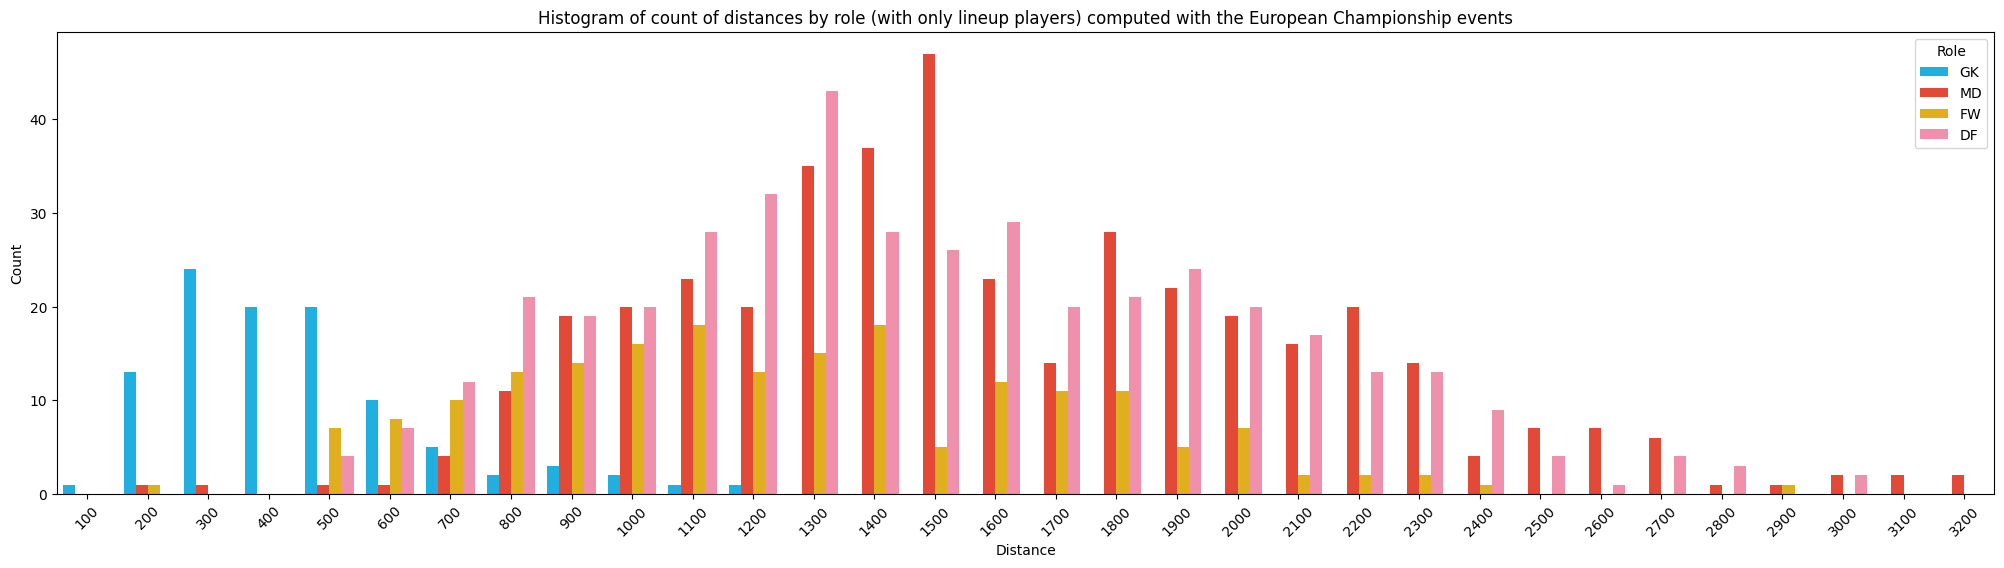

In [33]:
filtered_df, df1 = lineup_analysis(european_events_df, 'European_Championship', 'European Championship')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for European Championship


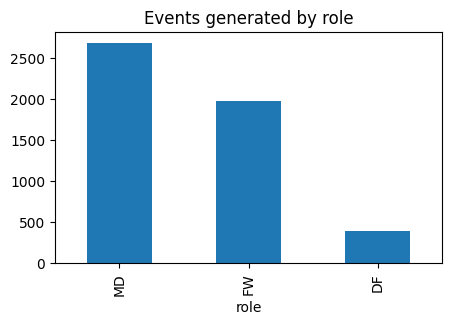

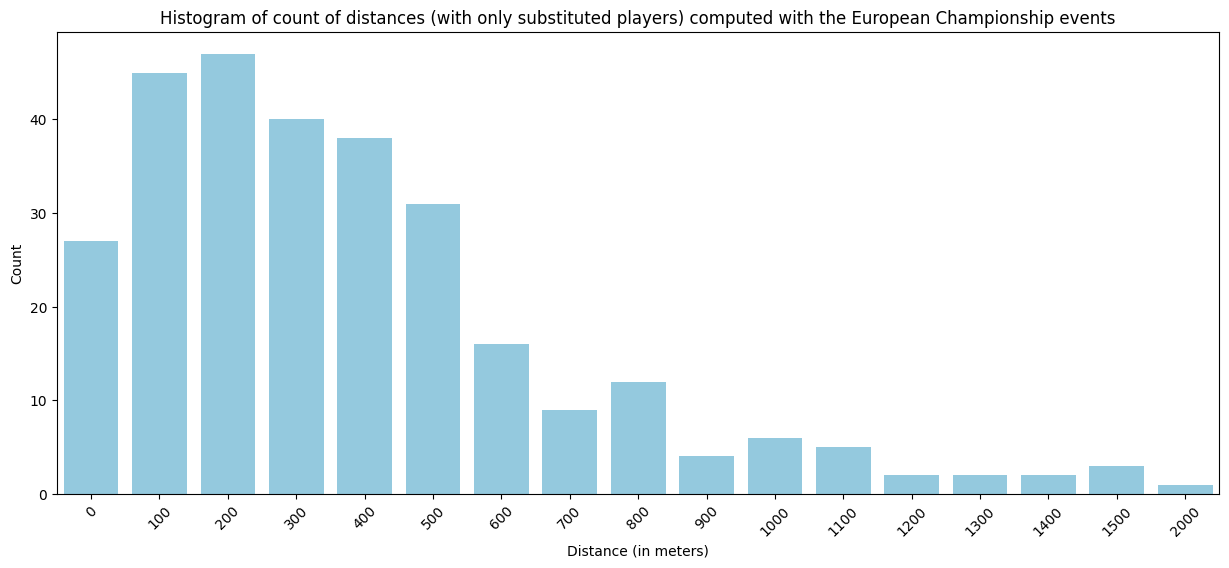

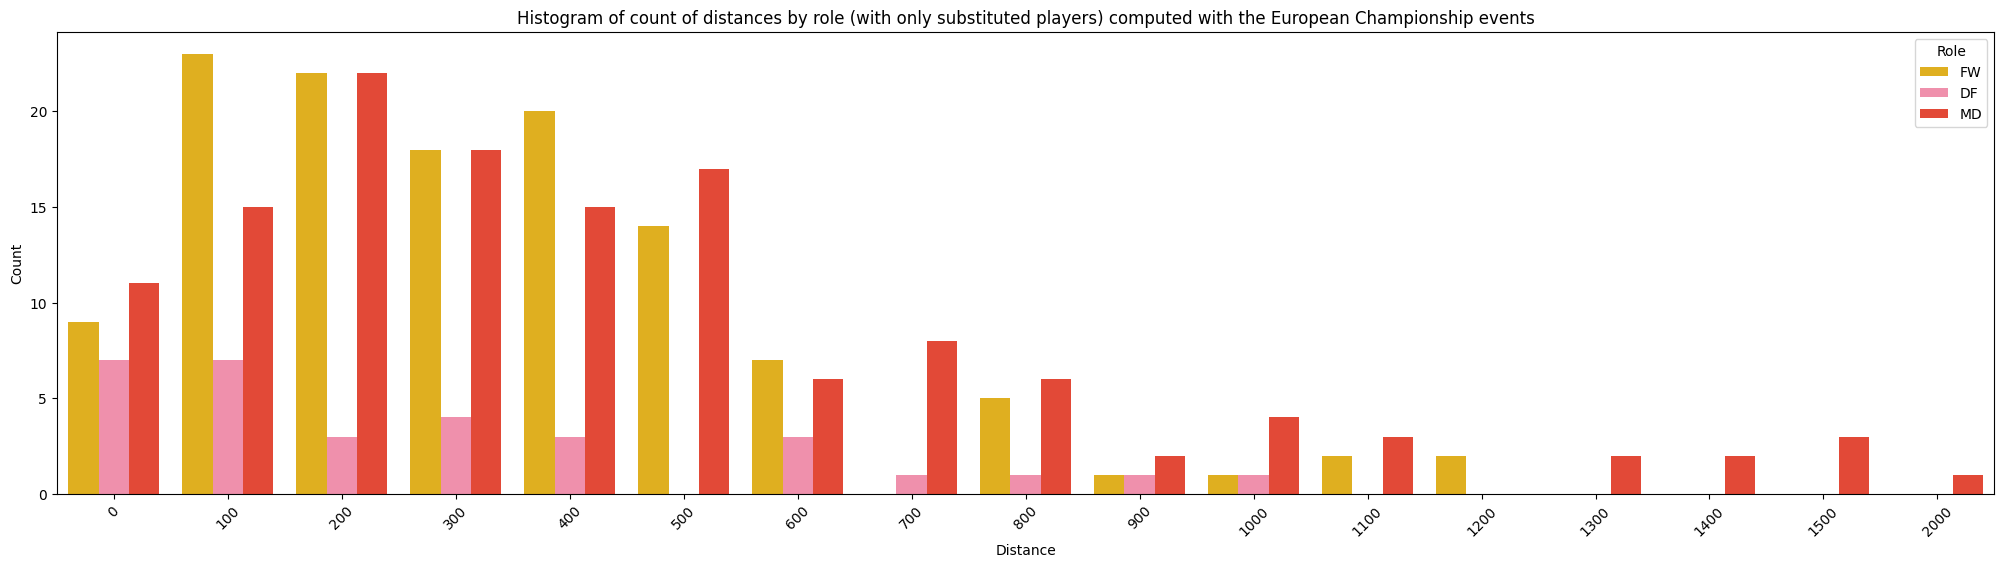

In [34]:
df1 = substitution_analysis(filtered_df, 'European_Championship', 'European Championship')

substitution_players_df = pd.concat([substitution_players_df, df1])

## World Cup

General analysis for World Cup


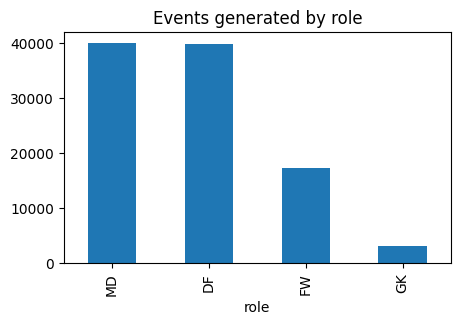

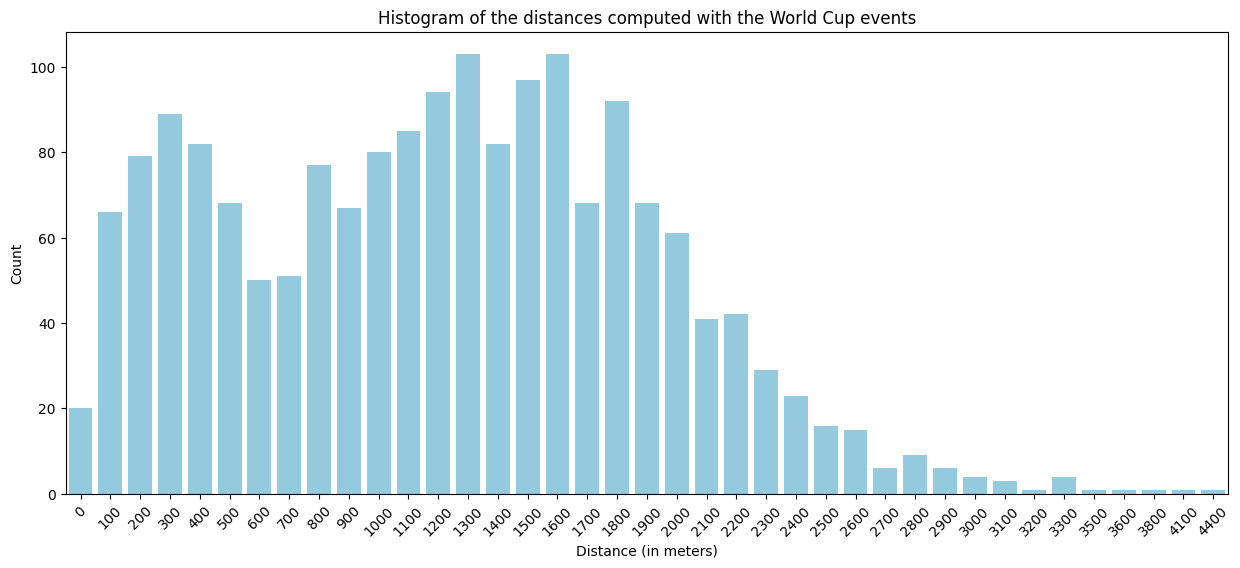

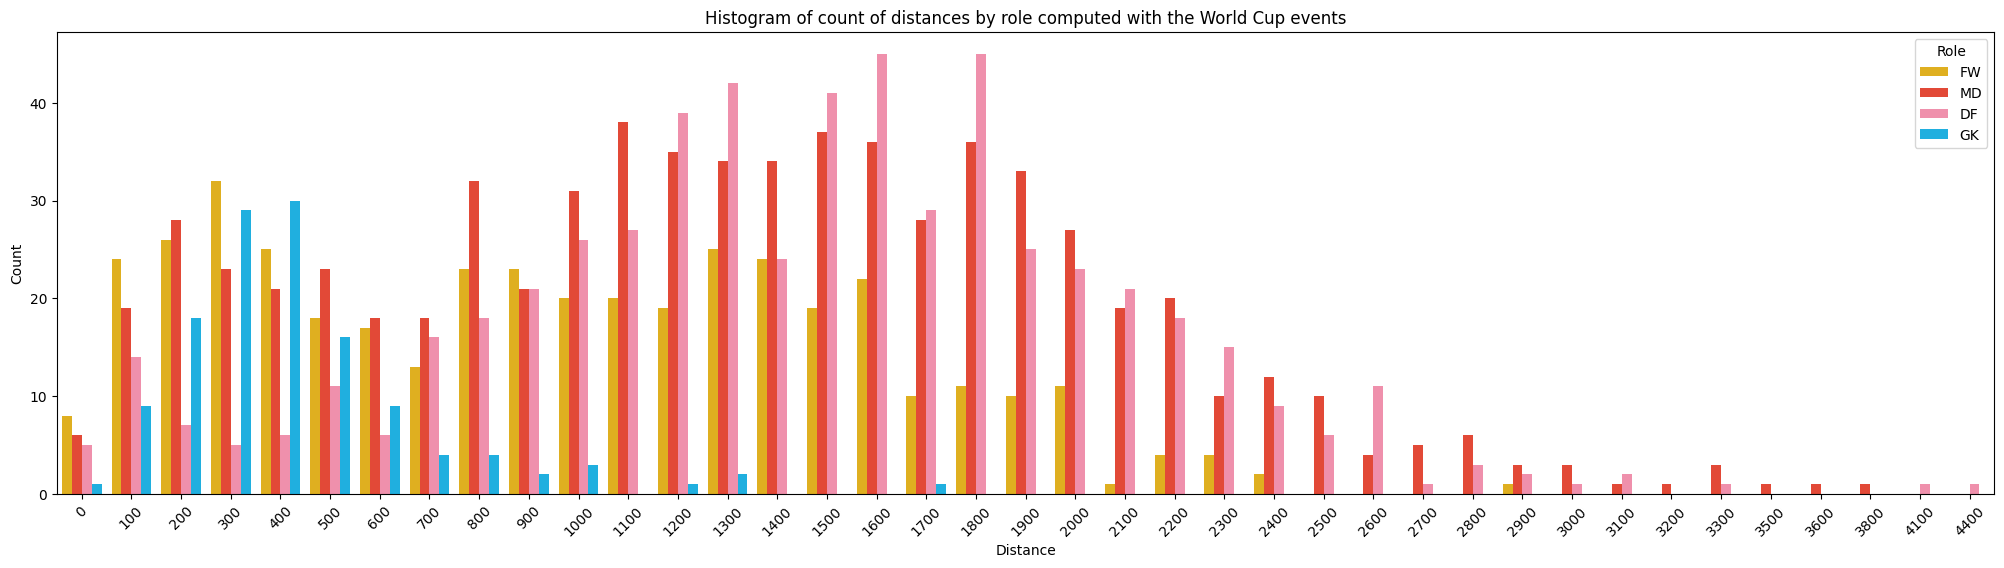

In [35]:
world_events_df, df1, df2 = general_analysis('World_Cup', 'World Cup')

total_tmp_df = pd.concat([total_tmp_df, df1])
total_player_role_df = pd.concat([total_player_role_df, df2])

Lineup analysis for World_Cup


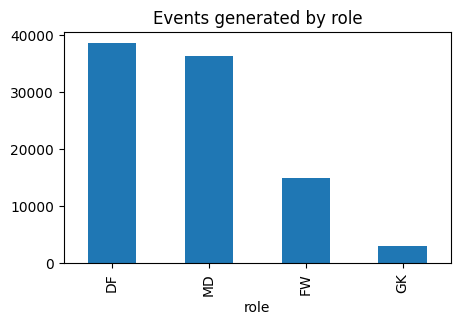

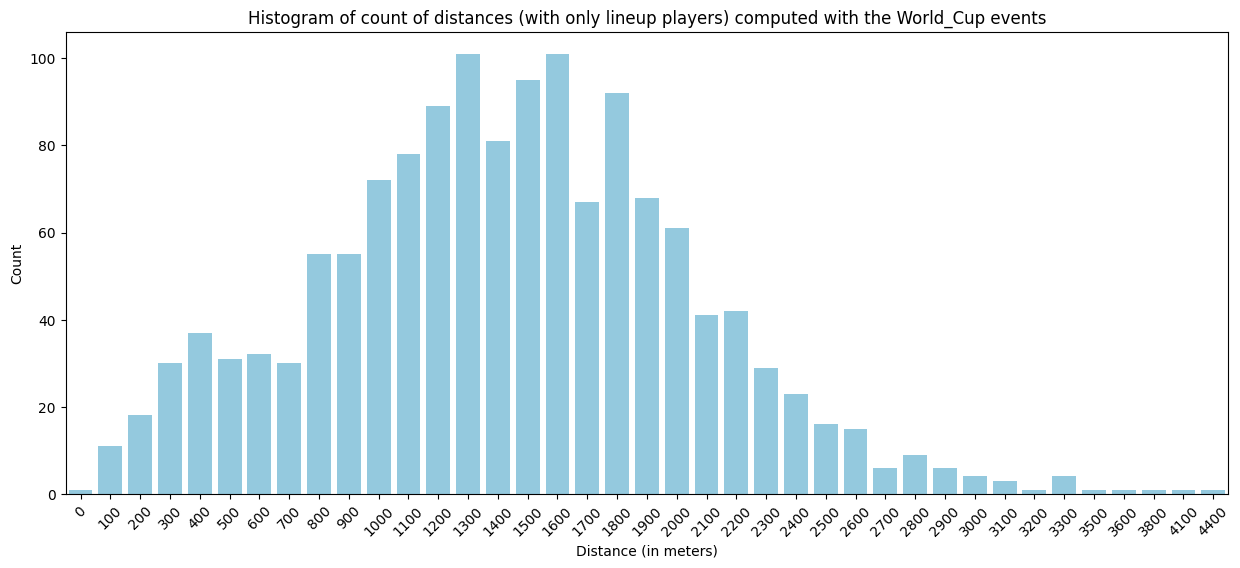

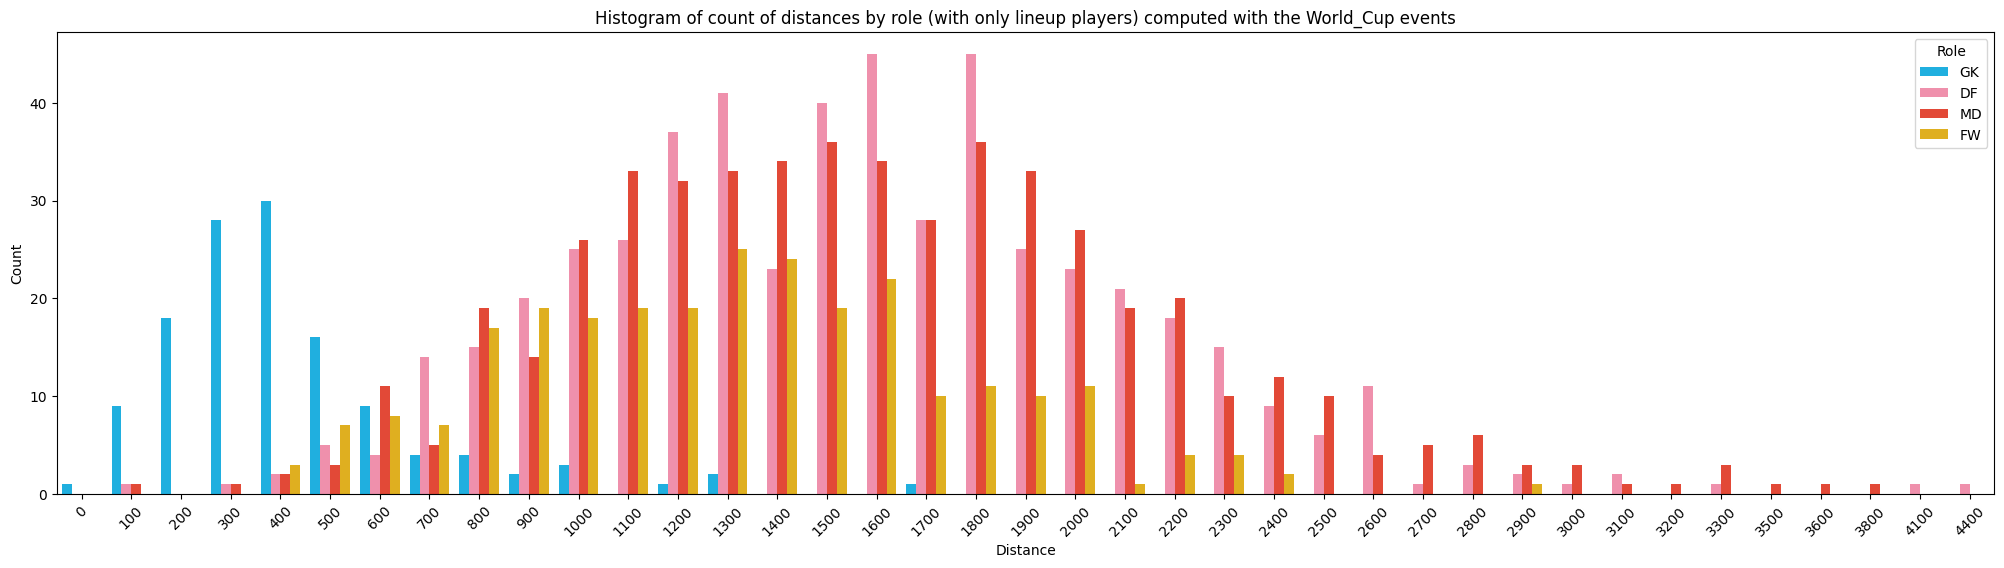

In [36]:
filtered_df, df1 = lineup_analysis(world_events_df, 'World_Cup', 'World_Cup')

lineup_players_df = pd.concat([lineup_players_df, df1])

Substitution analysis for World Cup


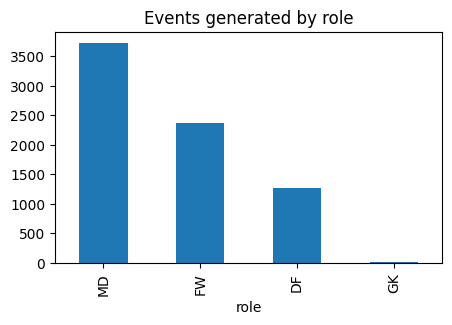

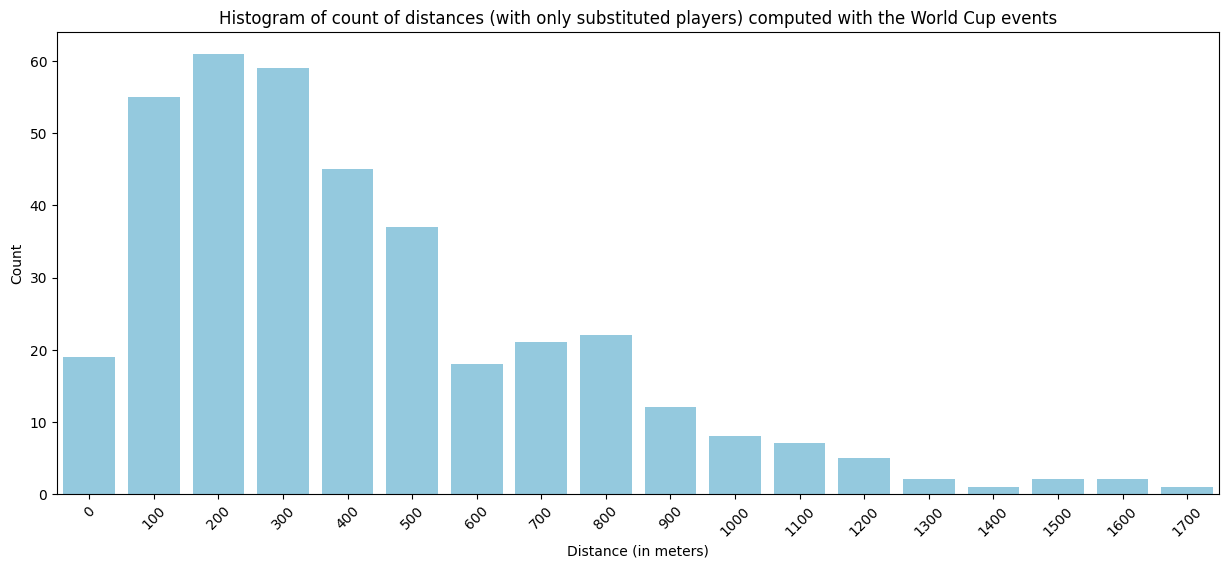

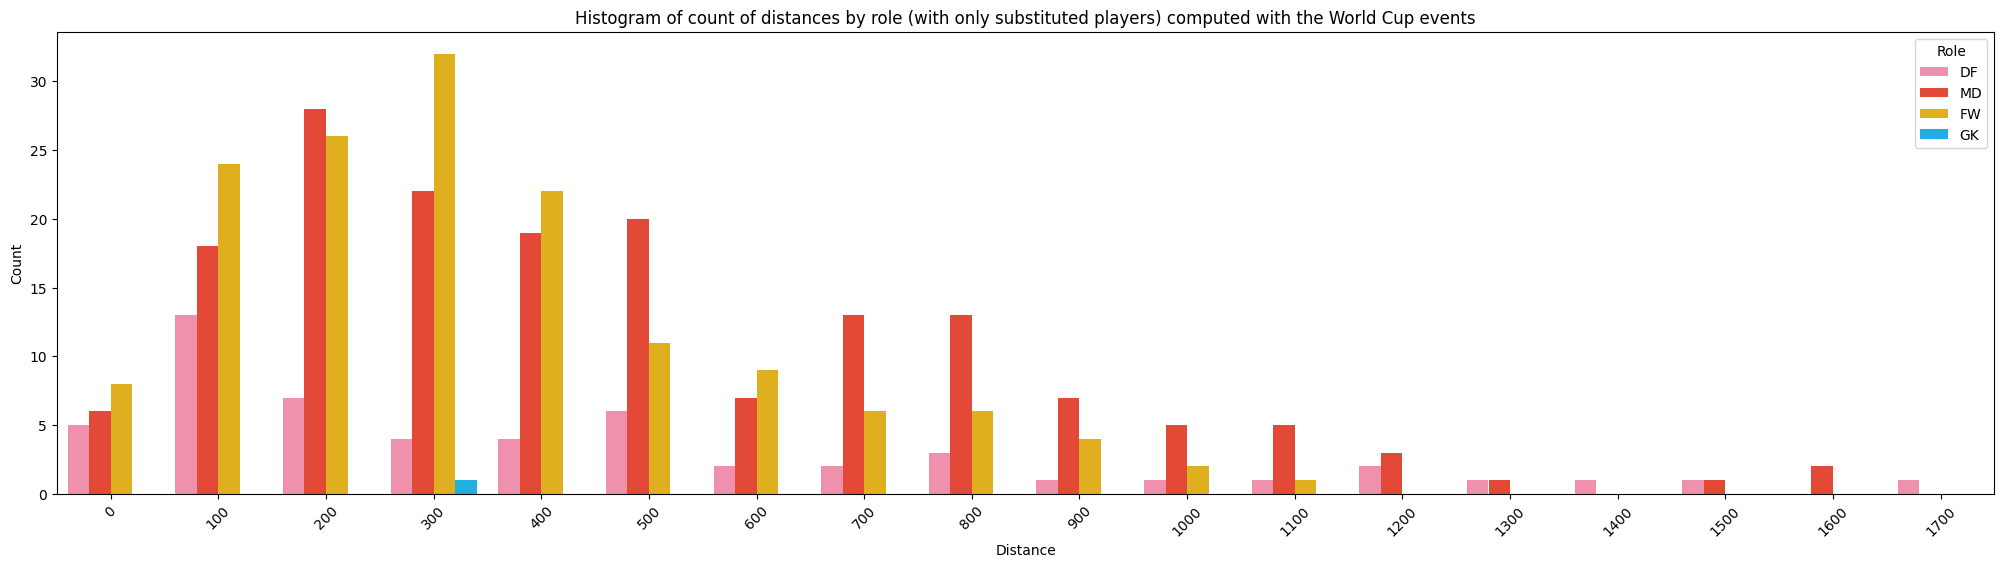

In [37]:
df1 = substitution_analysis(filtered_df, 'World_Cup', 'World Cup')

substitution_players_df = pd.concat([substitution_players_df, df1])

## Total distances

In conclusion, the following graphs summarize all the distributions shown. It is possible to appreciate, in these graphs, the Gaussian distributions present for all roles, which are a little less edgy and smoother than, in general, all the graphs previously present in this notebook.

General analysis


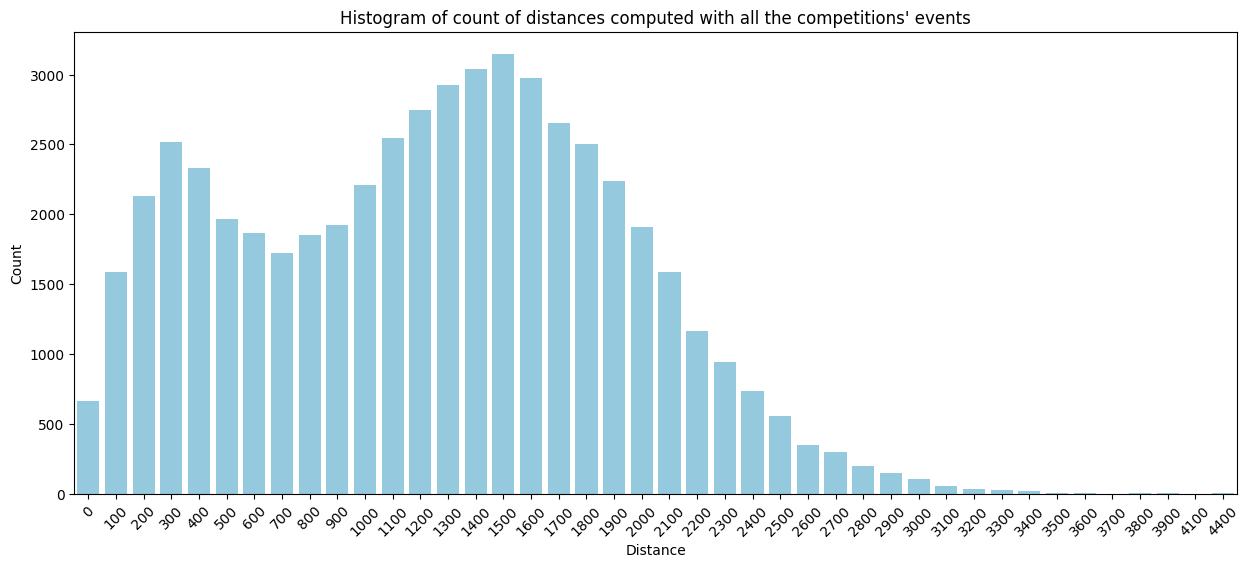

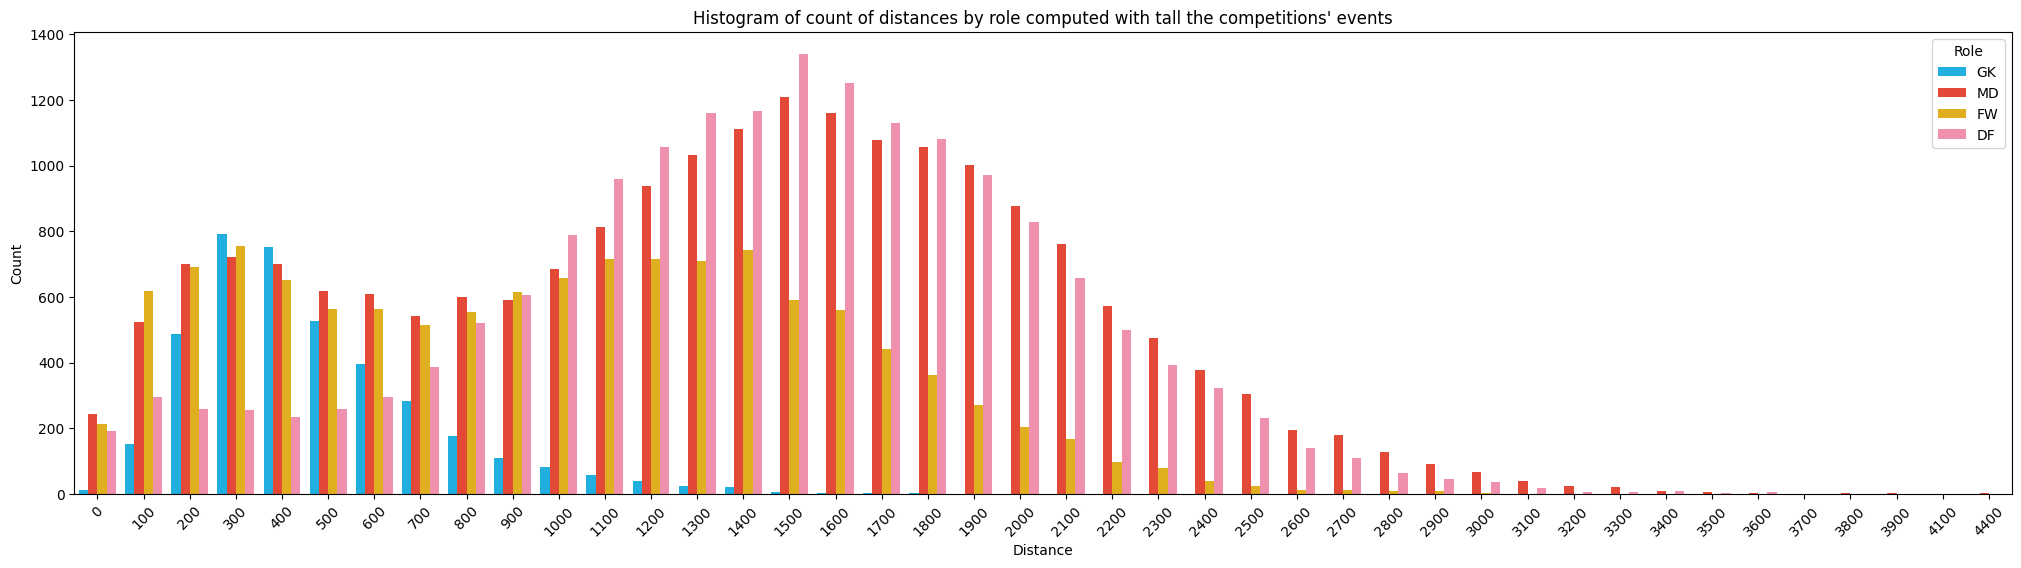

In [38]:
total_analysis()

Lineup analysis


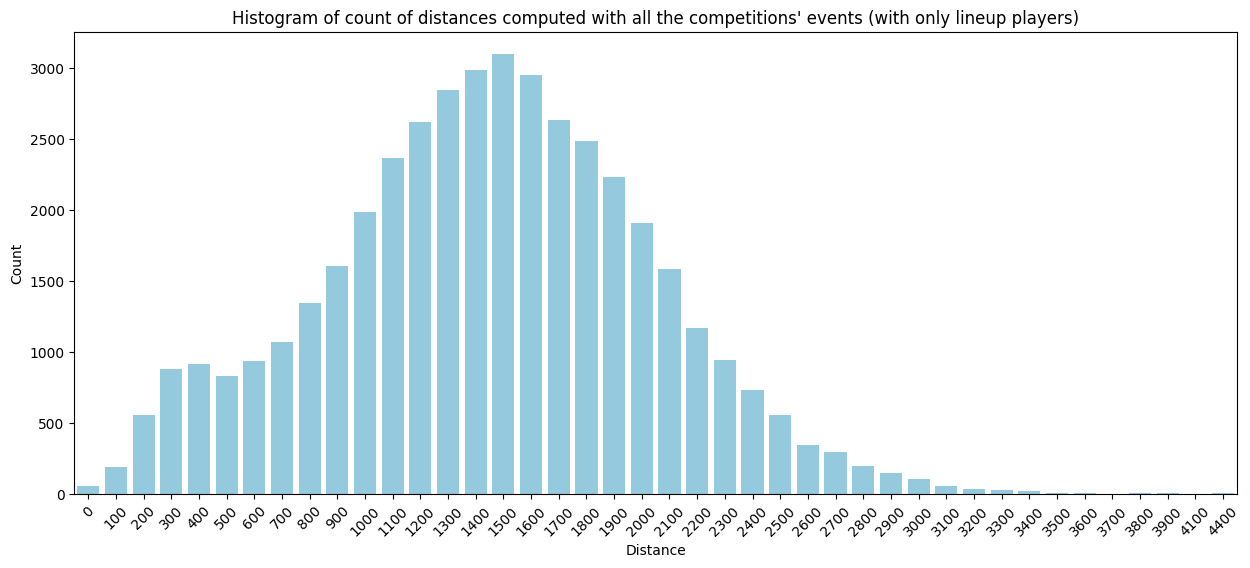

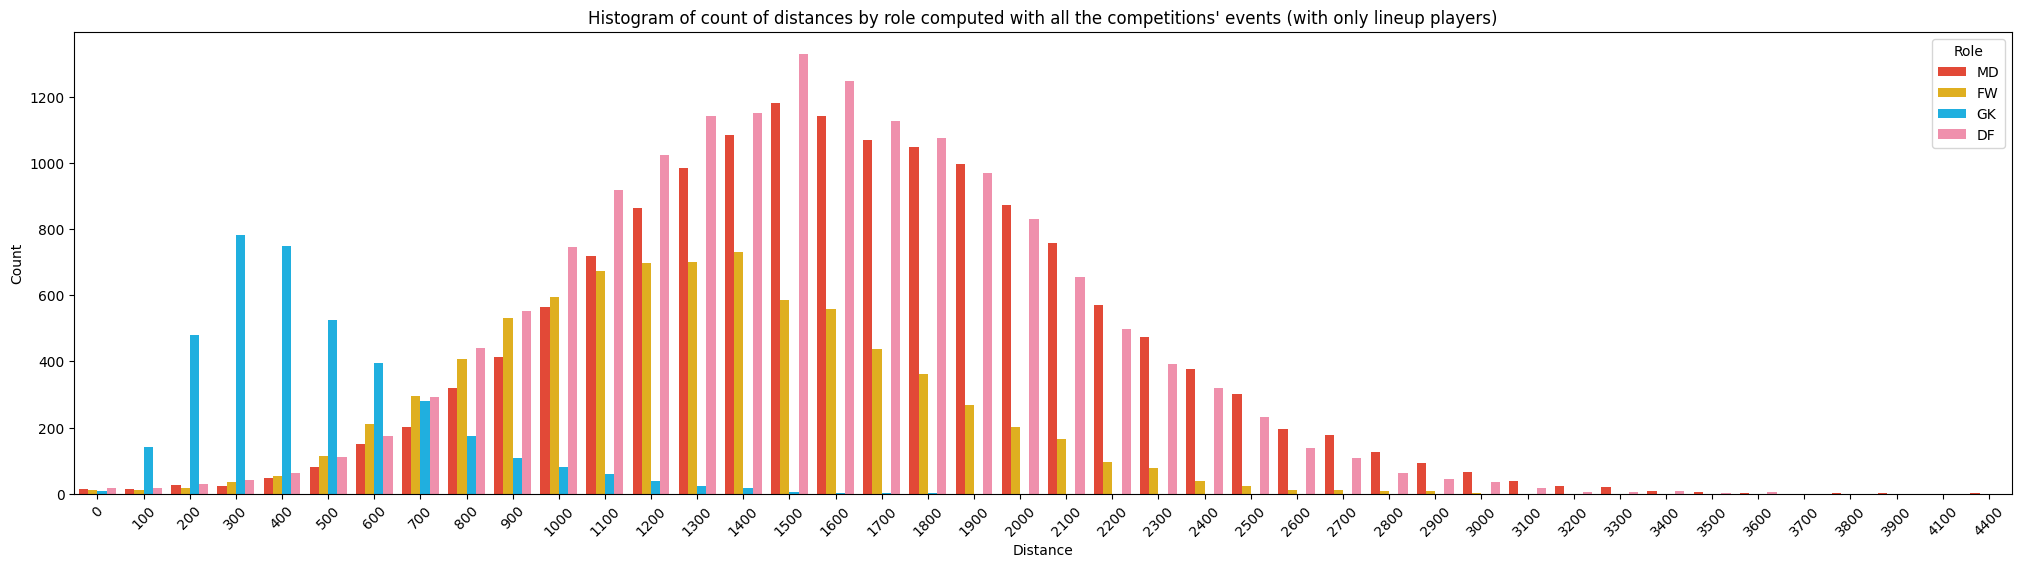

In [39]:
lineup_total_analysis()

Substitution analysis


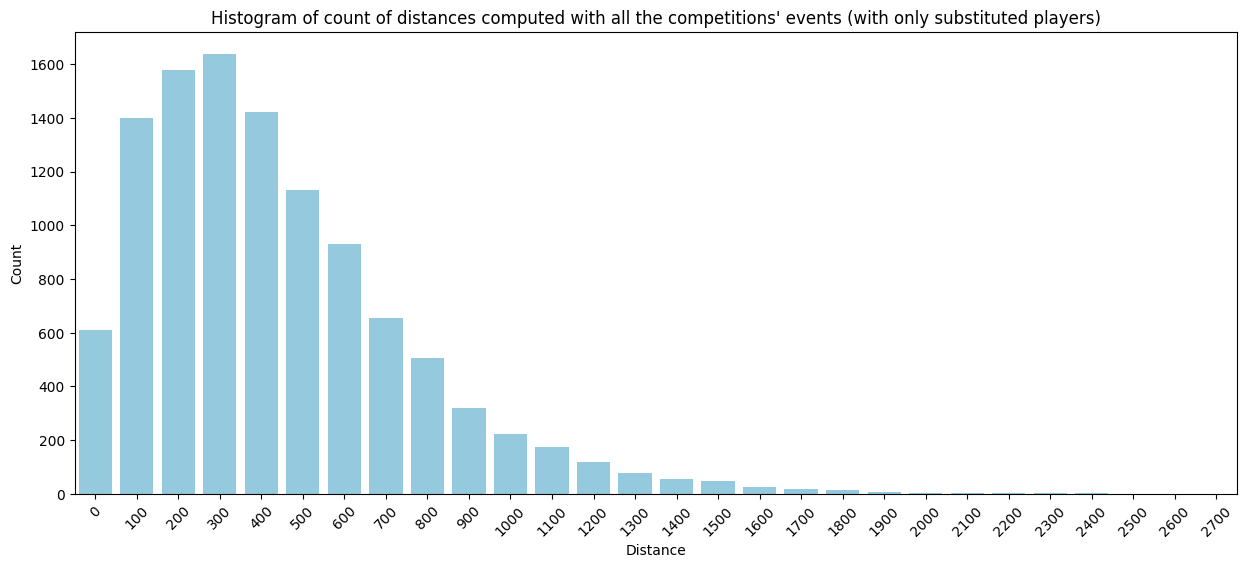

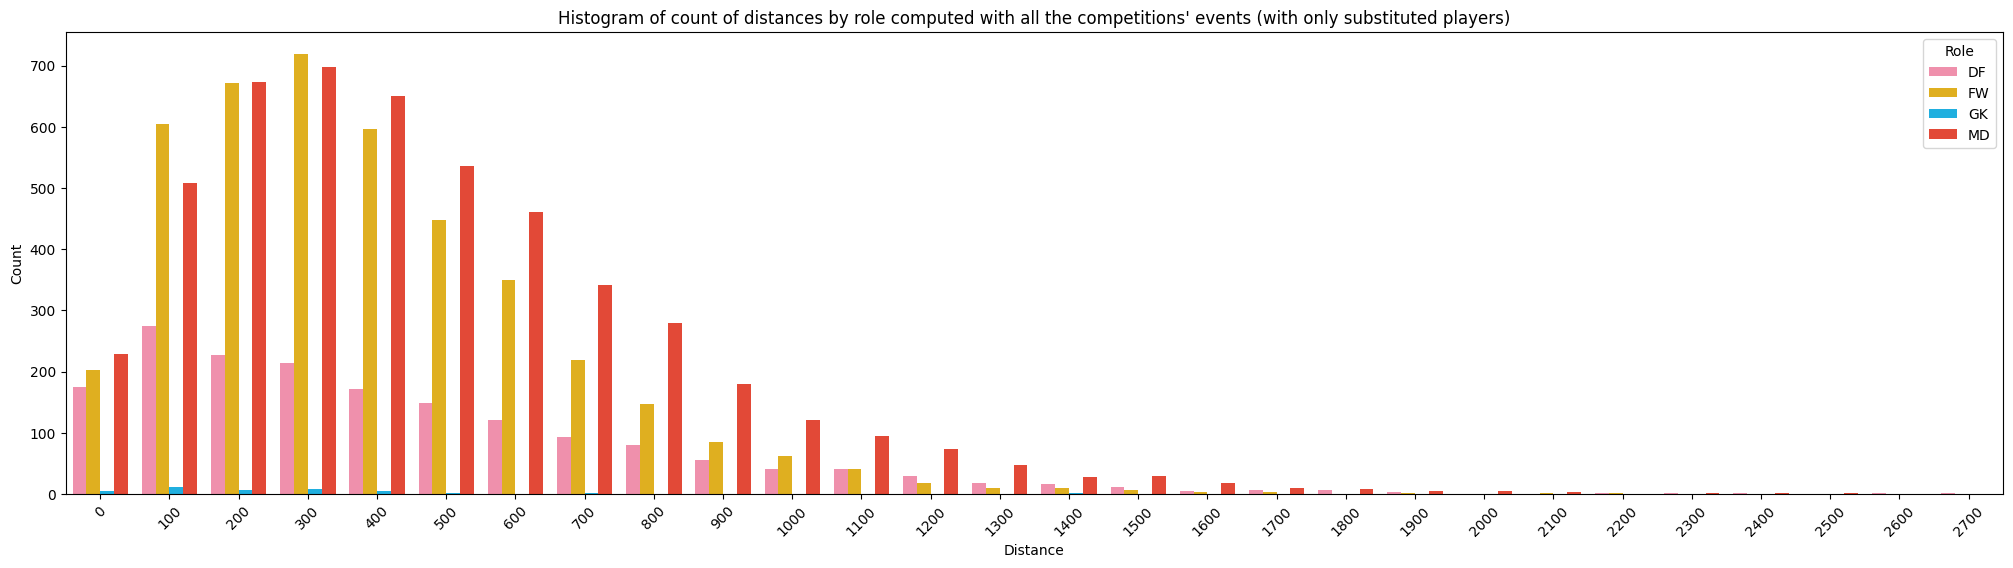

In [40]:
substitution_total_analysis()